In [1]:
import numpy as np
import pandas as pd

import pickle

import copy

import matplotlib.pyplot as plt

In [2]:
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(-1, '/mnt/x/Computation/Utilities')

import ocu_seaside.ocu_basics as se
import ocu_seaside.ocu_visuals as viz
import ocu_chisel as chis
import ocu_trident.ocu_tri_utils as tu
import ocu_binmeths as bm
import ocu_compass as co

import ocu_trident.ocu_deepstarr as ds
import ocu_trident.ocu_preassembled as pa
import ocu_oyster as oys

import os
os.chdir('/mnt/x/Computation/Projects/CS3-YY1/data/R2') ##########################

import torch
import torch.nn as nn
from torch.optim import Adam, AdamW

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
mainfolder = se.NewFolder('yy1_data')
fin_bins = se.PickleLoad(mainfolder + 'fin_bins')
print(fin_bins)

divset = ['Train', 'Stop.', ' Eval', 'Test']

xpsfolder = se.NewFolder('xps4')      

10


In [4]:
exact_folder = se.NewFolder('Oyster')
exact_iter = 11
pn_RO_exact = se.NewFolder(exact_folder + 'RO_' + str(exact_iter))
pn_RO_exact_top = se.NewFolder(pn_RO_exact + 'Top' + str(0))
exact_ranked_can_dict = se.PickleLoad(pn_RO_exact + 'ranked_can_dict')

exact_dict = exact_ranked_can_dict[0]

In [5]:
yy1_split_transaug = se.PickleLoad(mainfolder + 'yy1_split_transaug')

yy1_max = se.PickleLoad(mainfolder + 'yy1_max')

tri_tpacks = se.PickleLoad(mainfolder + 'tri_tpacks')

d_x1, d_y_ms, d_s, d_b, d_x2 = tri_tpacks

d_s_rs = np.swapaxes(np.expand_dims(d_s, axis = -1), 1, -1)

In [6]:
histones = ['H3K4me3', 'H3K27ac', 'H3K27me3', 'H3K4me1', 'H3K36me3', 'H3K9me3', 'H3K9ac', 
            'H3K4me2', 'H4K20me1', 'H2AFZ', 'H3K79me2']

In [7]:
xp6_trial = 2
xp6_id = 'xp6' + '_' + str(xp6_trial) 
pn_xp6 = se.NewFolder(xpsfolder + xp6_id)
pn_xpF, icof, icom = pn_xp6, 0, 3

pn_t1 = se.NewFolder(pn_xpF + str(icof))
pn_t2 = se.NewFolder(pn_t1 + str(icom))

ex_ens_idx = se.PickleLoad(pn_t2 + 'ensemble_idx')

ex_ens_pn_preds, ex_ens_pn_mods = [[pn_t2 + '0_' + str(ir) + s 
                                    for ir in ex_ens_idx]
                                   for s in ['_preds.p',  '_Mod.pt']]

#tu.LoadTorch(ex_ens_pn_mods[0])

In [8]:
exact_dict

{'A_dim_i': (1, 500, 4),
 'B_dim_i': (11, 40, 1),
 'dim_f': (1, 1, 1),
 'A_kE_ck_grouped': False,
 'A_DS': False,
 'A_kE_k': 15,
 'A_kE_cf_m': 150,
 'A_kE_cf_ns': 1.15,
 'A_kE_ck_base': 7,
 'A_kE_OneByOne': True,
 'A_P_ck': 50,
 'B_kE_ck_grouped': True,
 'B_DS': False,
 'B_kE_k': 10,
 'B_kE_cf_m': 30,
 'B_kE_cf_ns': 1,
 'B_kE_ck_base': 9,
 'B_kE_OneByOne': True,
 'B_P_ck': 5,
 'DS_wwp_func': torch.nn.modules.pooling.MaxPool2d,
 'DS_act': False,
 'P_center': True,
 'O_mods': 0,
 'O_mods_ns': 0.5,
 'O_cf_pu_m': None,
 'O_cf_ns': 1,
 'O_ck_base': None,
 'O_pool_k2s': 0,
 'O_pool_func': torch.nn.modules.pooling.MaxPool2d,
 'O_actb4pool': True,
 'O_dropout': 0.2,
 'activations': ReLU(),
 'batchnorm': 'before',
 'batchsize': 256,
 'learningrate': np.float64(0.00671949253976686)}

## Motifs 

In [9]:
tomain = '../../../../'

In [10]:
human_core_motifs = tomain + 'Essentials/motif_databases/HUMAN/HOCOMOCOv11_core_HUMAN_mono_meme_format.meme'

name_idx = 1
motif_names, motif_matrixes = se.MEME2Motifs(human_core_motifs, name_idx = name_idx)

motif_lengths = np.array([len(x) for x in motif_matrixes])

motif_names_filt = [a.split('_HUMAN')[0] for a in motif_names]

motif_names_revcomp = [x + '_R' for x in motif_names_filt]
motif_matrixes_revcomp = [np.flip(x, (-1, -2)) for x in motif_matrixes]

##################################

include_revcomp = not exact_dict['A_DS']

if include_revcomp: 

    motif_names_revcomp = [x + '_R' for x in motif_names_filt]
    motif_matrixes_revcomp = [np.flip(x, (-1, -2)) for x in motif_matrixes]

    all_names, all_matrixes = [x + y for x,y in [[motif_names_filt, motif_names_revcomp], 
                                                [motif_matrixes, motif_matrixes_revcomp]]]
    all_motif_lengths = np.hstack([motif_lengths, motif_lengths])

else: 

    all_names, all_matrixes = [motif_names_filt, motif_matrixes]
    all_motif_lengths = motif_lengths


##################################

yy1_motif_idx = all_names.index('TYY1')

# yy1_motif = all_matrixes[yy1_motif_idx]
# PickleDump(yy1_motif, mainfolder + "yy1_motif")
# LogomakerFromNumpy(yy1_motif)

##################################

### Motif Similarity

In [11]:
def PWMScorer(inp1, inp2, 
                 revcomp = False, 
                 sepwindows = False, extendbig = False,
                 score_mode = 'dot'):

    #inps can be 2 dim (length, width) or 3 dim (num, length, width)
    #its the smallest comparing to the largest one 

    #sep windows is that you dont do any summary on the window set

    #PWM score is the SUM of the product of the kmer and the OHE 

    #extendbig extends the bigger one by random (0.25)


    if len(inp1.shape) < 3: inp1 = np.expand_dims(inp1, axis = 0)
    if len(inp2.shape) < 3: inp2 = np.expand_dims(inp2, axis = 0)

    if extendbig: 
        exto = np.full((1, inp1.shape[1], 4), 0.25)
        inp2 = np.concatenate([exto, inp2, exto], axis = 1)

    lens = [x.shape[1] for x in [inp1, inp2]]

    if lens[0] < lens[1]:
        inp2s = [inp2[:, b:b+lens[0]] for b in range(lens[1]-lens[0]+1)]
    else: inp2s = [inp2]

    sha = inp2s[0].shape
    
    ST = np.lib.stride_tricks.sliding_window_view

    scos = []

    inpx = [inp1, np.flip(inp1, axis = (-1, -2))] if revcomp else [inp1]

    for inpj in inpx:

        for p2 in inp2s:

            w = ST(inpj, sha)[:, :, 0, 0] #You get shape of [num inp1, windows, lenwindow, widwindow]

            px = np.expand_dims(p2, 0) #now its shape [1, 1, lenwindow, widwindow]

            if score_mode == 'recipeuc':
                d1 = 1 / (np.sum(np.abs(w-px)**2, axis = (-1, -2))**(1/2))
            elif score_mode == 'euc':
                d1 = np.sum(np.abs(w-px)**2, axis = (-1, -2))**(1/2)
            else: #automatically goes to 'dot'
                d1 = np.sum(w * px, axis = (-1, -2))
           
            d2 = d1 if sepwindows else np.max(d1, axis = -1).reshape(-1, 1)

            scos.append(d2)
    
    if sepwindows:
        fin = np.hstack(scos) if lens[0] < lens[1] else np.vstack(scos)

    else:
        scos = np.stack(scos)
        ff = np.max
        fin = ff(scos, axis = 0)

    return fin



def CM2PFM(CM): 
    sums = np.sum(CM, axis = 1).reshape(-1, 1)
    return CM / sums



def kmersFromPPM(ppm, num = 10000, unique = False):

    lets = [np.random.choice(['A', 'C', 'G', 'T'], 
                                     size = num, replace = True, 
                                     p = px) for px in ppm]
    
    kmers = [''.join(row) for row in np.stack(lets, axis = 1)]

    if unique: kmers = list(np.unique(kmers))
    
    return kmers



def Oys_KmerContrib(model, inp,
                      sub_model = None, joint = False,
                      chunk = False): 
    
    #For no kmer associations

    mo = tu.LoadTorch(model) if isinstance(model, str) else model
    
    if sub_model is not None: mo = getattr(mo, sub_model)

    shapo = inp.shape

    with torch.no_grad(): 
        mo.eval()

        ger = 0 if isinstance(mo.O[0], nn.Conv2d) else 1

        Dweight = mo.O[ger].weight
        Dweight = torch.unsqueeze(Dweight, 0)

        x = inp

        if joint: x = mo.Reflect(x)

        x = mo.kE(x)
        x = torch.unsqueeze(x, axis = 1)
        
        print(x.shape, Dweight.shape) ######################

        x = x * Dweight

        if chunk: 
            xshapo = x.shape
            x = x.reshape(xshapo[0], xshapo[1], shapo[1], xshapo[2] // shapo[1], *xshapo[-2:])
            x = torch.sum(x, axis = 3)
        else: 
            x = torch.sum(x, axis = -3)

        if joint: x = torch.unsqueeze(torch.mean(x, axis = -1), dim= -1)

    return x.cpu().detach().numpy()



def Oys_ScorePPM(model, ppm,
                 
                 sub_model = None, joint = False, chunk = False,
                 score_mode = 'recipeuc',
                 
                 random_seqs = 10000, unique = True, 
                 scoreweight = True, batchsize = 256):

    #generates kmers from the ppm and scores them to the final output
    # CURRENTLY ONLY SUPPORTS ONE HEADED OYSTER MODEL
    #ppm must be the same size as what the Hydra head uses 
    #can do two types of scoring: distance or new method


    # recipeuc is reciprocal euclidean distance for weighting. Or else it would do the dot product. 
    # posres is positional resolution which for oyster models we do average pooling most times so you need to divide! 

    kmers = kmersFromPPM(ppm, num = random_seqs, unique = unique)
    kmers_OHE = chis.Seqs2OHE(kmers)

    lk = len(kmers)

    ####################### PWM SCORE #########################
    kmers_scored = PWMScorer(kmers_OHE, ppm, revcomp = joint, 
                                score_mode = score_mode).reshape(-1, 1, 1, 1) if scoreweight else 1
    print(kmers_scored.shape)

    fullbatches = lk // batchsize
    rem = lk % batchsize

    fins = []

    for fb in np.arange(fullbatches + (rem > 0)):

        fo = fb*batchsize

        batch = kmers_OHE[fo:fo + batchsize]

        if isinstance(model, list): 
            fin = []
            for m in model: 
                O = torch.FloatTensor(np.expand_dims(batch, axis = 1)).to(device)
                fin.append(Oys_KmerContrib(m, O, sub_model = sub_model, chunk = chunk))
            fin = np.mean(np.stack(fin), axis = 0)

        else: 

            O = torch.FloatTensor(np.expand_dims(batch, axis = 1)).to(device)
            fin = Oys_KmerContrib(model, O, sub_model = sub_model, chunk = chunk)
        
        fins.append(fin)
    
    fins = np.vstack(fins)

    #print(fins.shape, kmers_scored.shape)

    out = np.sum((fins * kmers_scored), axis = 0) / np.sum(kmers_scored) if scoreweight else np.mean(fins, axis = 0)

    return out

In [12]:
meto = 'euc'
fo, ass = (np.min, True) if meto == 'euc' else (np.max, False)


yy1_motif = all_matrixes[yy1_motif_idx]

yy1_dotmax = np.sum(yy1_motif * yy1_motif)

yy1_sim = []

for am in motif_matrixes: 

    sc = PWMScorer(yy1_motif, am,
                      revcomp = True, sepwindows = True, extendbig = True, 
                      score_mode=meto) #############
    
    yy1_sim.append(fo(sc)) #####################


yy1_sim_ms = se.Scaler(np.array(yy1_sim)) # / yy1_dotmax

yy1_sim_pd = pd.DataFrame(yy1_sim_ms, columns = ['YY1 Similarity'])
yy1_sim_pd.index = motif_names_filt
yy1_sim_pd.index.name = 'Motif'
yy1_sim_pd = yy1_sim_pd.sort_values('YY1 Similarity', ascending= ass, ignore_index=False)

yy1_sim_pd.to_excel(pn_t2 + 'yy1_sim_pd.xlsx')
                          
yy1_sim_pd[:20]

,YY1 Similarity
Motif,
TYY1,0.000000
ZFP42,0.334290
THAP1,0.440191
TAF1,0.569625
SOX17,0.697118
ZN586,0.724782
SRF,0.777206
CTCF,0.782696
ZN214,0.784981


In [13]:
# plt.plot(np.sort(yy1_sim_ms))
# plt.axhline(0.6)

### k-motifs

In [14]:
shif_names, shif_matrixes = [], []

leno = exact_dict['A_kE_k']

shif_idxs2 = []

idx_counter = 0
for n,m in zip(all_names, all_matrixes):
    shifm, shifn = se.ShiftedMotifs(m, length = leno, name = n)
    shif_names.extend(shifn)
    shif_matrixes.extend(shifm)

    lenoz = len(shifn)

    shif_idxs2.append(np.arange(lenoz) + idx_counter)

    idx_counter += lenoz

print(len(shif_matrixes), len(shif_names))

4054 4054


In [15]:
yy1_kppm_idxs = [ix for ix, x in enumerate(shif_names) if 'YY1' in x]

sw = True
uniq = True
smo = 'recipeuc'

hys_args = {'sub_model': 'OysterA', 'joint': exact_dict['A_DS'], 
            'random_seqs': 10000, 'unique': uniq, 
            'scoreweight': sw, 
            'score_mode': smo,
            'batchsize': 8192}

# shif_scores = []

# for ip, ppm in enumerate(shif_matrixes): #enumerate([shif_matrixes[x] for x in yy1_kppm_idxs]):
#     shif_scores.append(Oys_ScorePPM(ex_ens_pn_mods, ppm, **hys_args))
#     if ip % 10 == 0: print(f'finished {ip}')

# shif_scores = np.squeeze(np.stack(shif_scores))

# se.PickleDump(shif_scores, pn_t2 + 'shif_scores')

In [16]:
shif_scores = se.PickleLoad(pn_t2 + 'shif_scores')

mino, maxo = (np.round(f(shif_scores),4) for f in [np.min, np.max])
print(mino, maxo)

pdo = pd.DataFrame(data = np.array(shif_names), columns = ['k-Motif'])

poss = np.arange(len(shif_scores.T))
pdo[poss] = shif_scores

shif_scores_maxs2 = np.max(shif_scores, axis = 1)
sorto = np.argsort(np.abs(shif_scores_maxs2))[::-1]

pdx = pdo.iloc[sorto] #.iloc[:40]

pdx_sty = pdx.style.format(precision=3).background_gradient(cmap = 'Grays', axis = None, subset = poss,
                                                            vmin = mino, vmax = maxo)
pdx_sty.to_excel(pn_t2 + 'k-motifs.xlsx')

-0.3682 2.7334


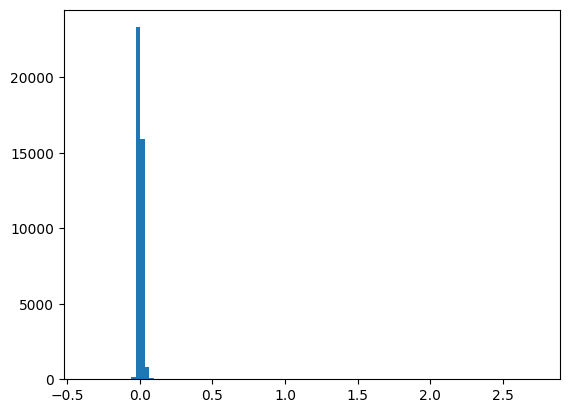

In [17]:
plt.hist(shif_scores.reshape(-1), bins = 100);

#### Summarized Motifs

In [18]:
def SummarizedPatterns(shif_scores, shif_idxs, k_size, 
                       seq_len, pos_reso,
                       center = False, pat_sizes = None): 
    # shif_scores = array of k-motifs, position blocks
    # shif_idxs = indexes of shif_scores belonging to each motif 
    # pos_reso = reso of positional blocks

    pb = shif_scores.shape[1]
    winx = seq_len - k_size + 1
    
    shif_scores_ext = np.repeat(shif_scores, pos_reso, axis = 1)[:, :seq_len]

    shifz_all = []

    for ido, do in enumerate(shif_idxs): 

        #get the shif_scores

        shifz = []
        pat_sizo = pat_sizes[ido]
        if pat_sizo < k_size: pat_sizo = k_size

        for ino, no in enumerate(do): 

            shifo_cut = shif_scores_ext[no][ino: seq_len - pat_sizo + 1 + ino]
            shifz.append(shifo_cut)
        
        shifz_sums = np.sum(np.stack(shifz), 0)

        if center:
            s1, s2 = pat_sizo // 2, int(np.ceil(pat_sizo/2))
            zer1, zer2 = [np.zeros((se)) for se in [s1, s2]]
            shifz_ext = np.hstack([zer1, shifz_sums, zer2])
        
        else: 
            shifz_ext = np.hstack([shifz_sums, np.zeros(pat_sizo - 1)])
        
        shifz_all.append(shifz_ext)

    return np.stack(shifz_all)

def SharedContribs(contribs, lengths, k_size, center = False): 
    # contribs is an array of size k-mer/pattern, length of original sequence 
    # The reverse complements are added to the contribs so the first half is sense and second is matching anti-sense
    # lengths are the lenght of the k-mer/pattern of size len(contribs) // 2

    #if center, that means the the contribs are also centered!!!!!!!!!!!!!!!!!!!! 
   
    tot = len(contribs)
    lengths = np.array(lengths)
    if len(lengths) == 1: lengths = np.repeat(lengths, tot//2)
    lengths[lengths < k_size] = k_size

    contribsx = []
    
    for con1, con2, siz in zip(contribs[:tot//2], contribs[tot//2:], lengths):

        if center: 
            s1, s2 = siz // 2, int(np.ceil(siz/2))
            conx1, conx2 = [con[s1:-s2-1] for con in [con1, con2]]
            conx2 = np.flip(conx2)
            conxo = (conx1 + conx2) / 2                                         #!!!!!!!!!!!! AVERAGED IT!!!!!!!!!!!!!!!
            zer1, zer2 = [np.zeros((se)) for se in [s1, s2]]
            contribsx.append(np.hstack([zer1, conxo, zer2]))            
        
        else:
            conx1, conx2 = [con[:-siz + 1] for con in [con1, con2]]
            conx2 = np.flip(conx2)
            conxo = (conx1 + conx2) / 2
            zers = np.zeros((siz-2))            
            contribsx.append(np.hstack([conxo, zers]))
        
    contribsx = np.stack(contribsx)

    return contribsx

In [19]:
centi = exact_dict['P_center']
resi = exact_dict['A_P_ck']
seqi = exact_dict['A_dim_i'][1]

sum_motifs_score = SummarizedPatterns(shif_scores, shif_idxs2, 
                                      k_size = leno, seq_len=seqi, pos_reso = resi,
                                      center = centi, pat_sizes = all_motif_lengths)

sum_motifs_score_shared = SharedContribs(sum_motifs_score, lengths = motif_lengths, k_size = leno,
                                         center = centi)                                         

sum_motifs_absmax = np.max(np.abs(sum_motifs_score_shared), axis = -1)


sorto = np.argsort(sum_motifs_absmax)[::-1]
thresh = 0.3
ot = np.where(sum_motifs_absmax.reshape(-1) > thresh)[0]
filt = np.array([s for s in sorto if s in ot])

sum_motifs_score_filt, all_names_filt = [x[filt] for x in [sum_motifs_score_shared, np.array(all_names)]]

all_names_filt

array(['TYY1', 'ZFP42', 'HXB4', 'RFX1', 'ZN528', 'NDF1', 'SP2', 'KLF12',
       'HIC1'], dtype='<U7')

In [20]:
sxpd = pd.DataFrame(data = sum_motifs_score_shared, columns = np.arange(seqi))
sxpd.index = motif_names_filt
sxpd.index.name = 'Motif'

sxpd = sxpd.iloc[sorto]

sxpd.to_excel(pn_t2 + 'sxpd.xlsx')

In [23]:
motif_matrixes[0].shape

(8, 4)

In [25]:
motif_maxsize = np.max([len(m) for mo in motif_matrixes for m in mo ])
motif_matrixes_ext = [np.vstack([x, np.zeros(motif_maxsize-len(x))]) 
                      for x in motif_matrixes]

motifs_display = [[motif_matrixes_ext[f], np.flip(motif_matrixes_ext[f], axis = (0,1))] for f in filt]


viz.MultiPlot(motifs_display, plt_mode = [viz.LogoPlot, {'xticks': False, 'ylabel': None}],
          multi = True, paired = True, transpose = True,
          rowtitle = all_names_filt, rowtitle_rotation = False,
          sharex = True, sharey = True, 
          figsize = (motif_maxsize * 0.3, len(filt) * 1.1));

ValueError: negative dimensions are not allowed

In [26]:
motif_matrixes_ext[0]

NameError: name 'motif_matrixes_ext' is not defined

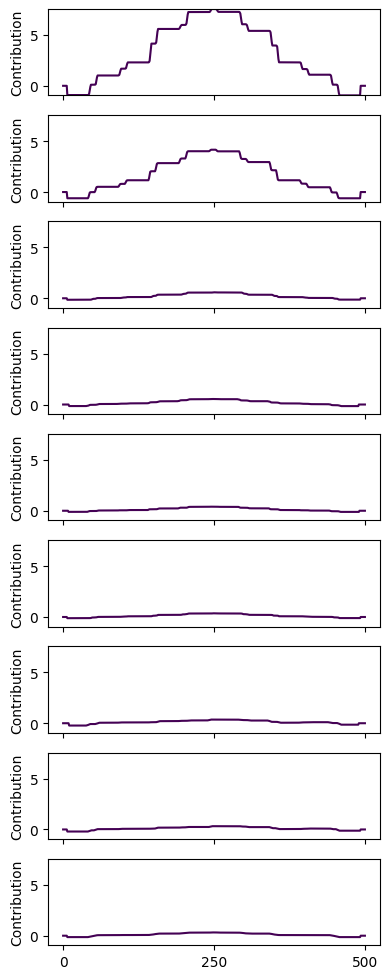

In [61]:
mp_args = {'multi': True, 'paired': False, 'transpose': False, 
           'columntitle': None,
           'rowtitle': None, 
           'rowtitle_rotation': False,
           'figsize': (4, len(filt) * 1.1), 'fontsize': 10,
           'sharey': True, 'sharex': True}

nucseqlen = 500

line_args = {'xticklabel': [0, nucseqlen // 2, nucseqlen], 
             'bounds': [sum_motifs_score_filt.min(), sum_motifs_score_filt.max()],
             'xlabel': None, 'ylabel': 'Contribution'}


viz.MultiPlot(sum_motifs_score_filt, **mp_args, customgrid=None,
                 plt_mode = [viz.LinePlot, line_args]);

# Functions

In [ ]:
def CM2PFM(CM): 
    sums = np.sum(CM, axis = 1).reshape(-1, 1)
    return CM / sums

def kmersFromPPM(ppm, num = 10000, unique = False):

    lets = [np.random.choice(['A', 'C', 'G', 'T'], 
                                     size = num, replace = True, 
                                     p = px) for px in ppm]
    
    kmers = [''.join(row) for row in np.stack(lets, axis = 1)]

    if unique: kmers = list(np.unique(kmers))
    
    return kmers

def Oys_KmerContrib_vX(model, inp,
                      sub_model = None,
                      chunk = False): 
    
    #For no kmer associations

    if isinstance(model, str): model = tu.LoadTorch(model)

    if sub_model is None: sub_model = ''

    shapo = inp.shape

    with torch.no_grad(): 
        model.eval()

        if isinstance(getattr(model, 'P' + sub_model), nn.Identity): 
            reso = 1
        else: 
            reso = getattr(model, 'P' + sub_model).kernel_size[0]


        Dweight = getattr(model, 'D' + sub_model)[0].weight
        Dweight = torch.unsqueeze(Dweight, 0)

        x = inp
        x = getattr(model, 'Reflect' + sub_model)(x)
        x = getattr(model, 'H' + sub_model)(x)
        x = getattr(model, 'O' + sub_model)(x)
        x = getattr(model, 'J' + sub_model)(x)

        x = torch.unsqueeze(x, axis = 1)
        
        #print(x.shape, Dweight.shape) ######################

        x = x * Dweight

        if chunk: 
            xshapo = x.shape
            x = x.reshape(xshapo[0], xshapo[1], shapo[1], xshapo[2] // shapo[1], *xshapo[-2:])
            x = torch.sum(x, axis = 3)
        else: 
            x = torch.sum(x, axis = -3)

    return x.cpu().detach().numpy() / reso ########### DIVIDE BY RESO

def Oys_ScorePPM_vX2(model, ppm,
                       
                       sub_model = None, joint = False, chunk = False,

                       recipeuc = False,
                       
                       random_seqs = 10000, unique = True, 
                       
                       scoreweight = True, 
                       batchsize = 256):

    #generates kmers from the ppm and scores them to the final output
    # CURRENTLY ONLY SUPPORTS ONE HEADED OYSTER MODEL
    #ppm must be the same size as what the Hydra head uses 
    #can do two types of scoring: distance or new method


    # recipeuc is reciprocal euclidean distance for weighting. Or else it would do the dot product. 
    # posres is positional resolution which for oyster models we do average pooling most times so you need to divide! 

    kmers = kmersFromPPM(ppm, num = random_seqs, unique = unique)
    kmers_OHE = Seqs2OHE(kmers)

    lk = len(kmers)
    
    ####################### PWM SCORE #########################
    kmers_scored = PWMScorer(kmers_OHE, ppm, revcomp = joint, recipeuc = recipeuc).reshape(-1, 1, 1, 1) if scoreweight else 1
    print(kmers_scored.shape)

    fullbatches = lk // batchsize
    rem = lk % batchsize

    fins = []

    for fb in np.arange(fullbatches + (rem > 0)):

        fo = fb*batchsize

        batch = kmers_OHE[fo:fo + batchsize]

        if isinstance(model, list): 
            fin = []
            for m in model: 
                O = torch.FloatTensor(np.expand_dims(batch, axis = 1)).to(device)
                fin.append(Oys_KmerContrib_vX(m, O, sub_model = sub_model, chunk = chunk))
            fin = np.mean(np.stack(fin), axis = 0)

        else: 

            O = torch.FloatTensor(np.expand_dims(batch, axis = 1)).to(device)
            fin = Oys_KmerContrib_vX(model, O, sub_model = sub_model, chunk = chunk)
        
        fins.append(fin)
    
    fins = np.vstack(fins)

    #print(fins.shape, kmers_scored.shape)

    out = np.sum((fins * kmers_scored), axis = 0) / np.sum(kmers_scored) if scoreweight else np.mean(fins, axis = 0)

    return out

In [11]:
from sklearn.cluster import KMeans

def TridentWindow(inp, size): 
    ST = np.lib.stride_tricks.sliding_window_view
    winshape = (inp.shape[1], size, inp.shape[-1])
    sig_win = ST(inp, (1, *winshape))
    sig_win_rs = sig_win.reshape(-1, *winshape)
    return sig_win_rs


def Oys_ScoreSignals(model, inp, 
                     sub_model = '', chunk = False,
                     batchsize = 256):


    #inp is a trident pack with (num, signal, length, wid) 

    #sig_win_rs = TridentWindow(inp, H_size)
    sig_win_rs = inp

    lk = len(sig_win_rs)

    fullbatches = lk // batchsize
    rem = lk % batchsize

    fins = []

    for fb in np.arange(fullbatches + (rem > 0)):

        fo = fb*batchsize

        batch = sig_win_rs[fo:fo + batchsize]

        if isinstance(model, list): 
            fin = []
            for m in model: 
                O = torch.FloatTensor(batch).to(device)
                fin.append(Oys_KmerContrib_vX(m, O, sub_model = sub_model, chunk = chunk))
            fin = np.mean(np.stack(fin), axis = 0)
        
        else: 

            O = torch.FloatTensor(batch).to(device)
            fin = Oys_KmerContrib_vX(model, O, sub_model = sub_model, chunk = chunk)
        
        fins.append(fin)
    
    fins = np.vstack(fins)

    return fins[:, 0] # to get (number, signs, pos, 1) 

def Oys_SigCluster(inp, H_size,
                      num_clusters = 10, sample = None,
                      chunk = True, 
                      cluster_mode = [KMeans, {}]):
        
    sig_win_rs = TridentWindow(inp, H_size)
    num_sigs = inp.shape[1]
    
    lk = len(sig_win_rs)

    if isinstance(sample, int): 
        rando = np.random.choice(np.arange(lk), sample, replace=False)

    if chunk: 

        clustod = []
        for i in np.arange(num_sigs):

            sig = sig_win_rs[:, i].reshape(lk, -1)
            sig_samp = sig[rando] if isinstance(sample, int) else sig
            
            clust = cluster_mode[0](n_clusters = num_clusters, **cluster_mode[1])
            clust.fit(sig_samp)

            clustod.append(clust.predict(sig))

            print(f'finished: {i}')
        
        clustod = np.stack(clustod, axis = 1)
    
    return clustod


def Oys_SigCentroids(wins, contribs, clusters, weighted = True):
    #wins shape = (number, signal, k, 1)
    #contribs shape = (number, signal, pos, 1)
    #clusters shape = (number, signal) 

    #this gets the centroids and their score per position 

    #weighted is to get a weighted centroid, weighted by the DISTANCE!!!!!!!!!!!
    # p = mink distance
    num_sigs = contribs.shape[1]

    centroids_all = []
    contrib_cents_all = []

    for s in np.arange(num_sigs): 

        centroids = []
        contrib_cents = []

        clus = np.unique(clusters[:, s])

        for c in clus: 

            wino = wins[:, s][clusters[:, s] == c] #this is now (num, k, 1) 

            centroid = np.mean(wino, axis = 0) #this is now (k, 1)
            centroids.append(centroid)

            contribo = contribs[:, s][clusters[:, s] == c] #this is now (num, pos, 1) 

            if weighted: ################################ NEED TO EDIT THIS FOR THE RECEUC
                    
                scores = np.sum(wino * np.expand_dims(centroid, axis = 0), axis = (-1, -2)).reshape(-1, 1, 1)
                print(scores.shape)     
                
                contrib_cent = np.sum(contribo * scores, axis = 0) / np.sum(scores)
            
            else: 

                contrib_cent = np.mean(contribo, axis = 0)
            
            contrib_cents.append(contrib_cent)

        centroids_all.append(np.stack(centroids)) 
        contrib_cents_all.append(np.stack(contrib_cents))

    return centroids_all, contrib_cents_all

In [12]:
def GetCentroids(signal, clusters):
    #signal is a (n, *) shape and clusters is a 1dim
    return np.stack([np.mean(signal[clusters == b], axis = 0) for b in np.unique(clusters)])


from kneed import KneeLocator

def RefineClusters(signal, clusters, return_newcents = False):
                   
    
    #uses agglomerative clsutering on centroids 

    clust1_uni = np.unique(clusters)


    cents1 = GetCentroids(signal, clusters)
    model1 = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
    model1 = model1.fit(cents1)

    kn = KneeLocator(np.arange(len(model1.distances_)), model1.distances_, curve='convex', direction='increasing')
    kno = kn.knee

    model2 = AgglomerativeClustering(distance_threshold=model1.distances_[kno], n_clusters=None)
    clust2 = model2.fit_predict(cents1) #you have a lst the length of unique clusters


    clust2_uni = np.unique(clust2)
    
    print(f'from {len(clust1_uni)} to {len(clust2_uni)}')

    clust2_sepidx = [clust1_uni[clust2 == u] for u in clust2_uni] #This now tells you which of the original clusters belongs to each new cluster 


    newclust = np.ones(len(clusters))
    for u,g in zip(clust2_uni, clust2_sepidx): 
        for h in g:
            newclust[clusters == h] = u 
    

    newcents = GetCentroids(signal, newclust)

    return (newclust, newcents) if return_newcents else newclust

In [13]:
def ExpandedContribs(contribs, seq_len, k, center = False): 
    # expands the contribs of size k to the sequence length
    kl = seq_len-k+1
    contribs_exp = np.repeat(contribs, np.ceil(kl / contribs.shape[1]), axis = 1)
    contribs_exp = contribs_exp[:, :kl]
    if center: 
        so = seq_len-kl
        exp1 = np.zeros((contribs.shape[0], so // 2))
        exp2 = np.zeros((contribs.shape[0], int(np.ceil(so / 2))))
        ret = np.hstack([exp1, contribs_exp, exp2])
    else: 
        expo = np.zeros((contribs.shape[0], seq_len-kl))
        ret = np.hstack([contribs_exp, expo])
    return ret

def SummarizedPatterns(shif_scores, shif_idxs, k_size, 
                       seq_len, pos_reso,
                       center = False, pat_sizes = None): 
    # shif_scores = array of k-motifs, position blocks
    # shif_idxs = indexes of shif_scores belonging to each motif 
    # pos_reso = reso of positional blocks

    pb = shif_scores.shape[1]
    winx = seq_len - k_size + 1
    
    shif_scores_ext = np.repeat(shif_scores, pos_reso, axis = 1)[:, :seq_len]

    shifz_all = []

    for ido, do in enumerate(shif_idxs): 

        #get the shif_scores

        shifz = []
        pat_sizo = pat_sizes[ido]
        if pat_sizo < k_size: pat_sizo = k_size

        for ino, no in enumerate(do): 

            shifo_cut = shif_scores_ext[no][ino: seq_len - pat_sizo + 1 + ino]
            shifz.append(shifo_cut)
        
        shifz_sums = np.sum(np.stack(shifz), 0)

        if center:
            s1, s2 = pat_sizo // 2, int(np.ceil(pat_sizo/2))
            zer1, zer2 = [np.zeros((se)) for se in [s1, s2]]
            shifz_ext = np.hstack([zer1, shifz_sums, zer2])
        
        else: 
            shifz_ext = np.hstack([shifz_sums, np.zeros(pat_sizo - 1)])
        
        shifz_all.append(shifz_ext)

    return np.stack(shifz_all)

def SharedContribs(contribs, lengths, k_size, center = False): 
    # contribs is an array of size k-mer/pattern, length of original sequence 
    # The reverse complements are added to the contribs so the first half is sense and second is matching anti-sense
    # lengths are the lenght of the k-mer/pattern of size len(contribs) // 2

    #if center, that means the the contribs are also centered!!!!!!!!!!!!!!!!!!!! 
   
    tot = len(contribs)
    lengths = np.array(lengths)
    if len(lengths) == 1: lengths = np.repeat(lengths, tot//2)
    lengths[lengths < k_size] = k_size

    contribsx = []
    
    for con1, con2, siz in zip(contribs[:tot//2], contribs[tot//2:], lengths):

        if center: 
            s1, s2 = siz // 2, int(np.ceil(siz/2))
            conx1, conx2 = [con[s1:-s2-1] for con in [con1, con2]]
            conx2 = np.flip(conx2)
            conxo = (conx1 + conx2) / 2
            zer1, zer2 = [np.zeros((se)) for se in [s1, s2]]
            contribsx.append(np.hstack([zer1, conxo, zer2]))            
        
        else:
            conx1, conx2 = [con[:-siz + 1] for con in [con1, con2]]
            conx2 = np.flip(conx2)
            conxo = (conx1 + conx2) / 2
            zers = np.zeros((siz-2))            
            contribsx.append(np.hstack([conxo, zers]))
        
    contribsx = np.stack(contribsx)

    return contribsx

In [14]:
def SummarizedPatterns(shif_scores, shif_idxs, k_size, 
                       seq_len, pos_reso,
                       center = False, pat_sizes = None): 
    # shif_scores = array of k-motifs, position blocks
    # shif_idxs = indexes of shif_scores belonging to each motif 
    # pos_reso = reso of positional blocks

    pb = shif_scores.shape[1]
    winx = seq_len - k_size + 1
    
    shif_scores_ext = np.repeat(shif_scores, pos_reso, axis = 1)[:, :seq_len]

    shifz_all = []

    for ido, do in enumerate(shif_idxs): 

        #get the shif_scores

        shifz = []
        pat_sizo = pat_sizes[ido]
        if pat_sizo < k_size: pat_sizo = k_size

        for ino, no in enumerate(do): 

            shifo_cut = shif_scores_ext[no][ino: seq_len - pat_sizo + 1 + ino]
            shifz.append(shifo_cut)
        
        shifz_sums = np.sum(np.stack(shifz), 0)

        if center:
            s1, s2 = pat_sizo // 2, int(np.ceil(pat_sizo/2))
            zer1, zer2 = [np.zeros((se)) for se in [s1, s2]]
            shifz_ext = np.hstack([zer1, shifz_sums, zer2])
        
        else: 
            shifz_ext = np.hstack([shifz_sums, np.zeros(pat_sizo - 1)])
        
        shifz_all.append(shifz_ext)

    return np.stack(shifz_all)

# Ensemble2 Interpretations

In [25]:
xp, xp_config, xp_unit = 'xpPAD', 0, 1 #######################
bestloc2 = NewFolder(moved + xp + '/' + str(xp_config) + '/' + str(xp_unit))

ensemb2_idxs = EnsembleIdxs(bestloc2, std_cutoff = 2, ddof = 1)

pn_ensemb2_preds, pn_ensemb2_mod = [[bestloc2 + '0_'+ str(b) + x for b in ensemb2_idxs] 
                                  for x in ['_preds.p',  '_Mod.pt']]

In [26]:
dx2_sel = dx2[:, [9]]

bob_candict = PickleLoad(pn_bcs + 'bob_candict')

ensemb2_config = copy.deepcopy(bob_candict)
ensemb2_config.update({'B_dim_i': dx2_sel.shape[1:], 
                       'A_joint': False ##### Since A_doublestrand was false, it actually didnt use it                       
                       })

In [27]:
ensemb2_config

{'A_dim_i': (1, 500, 4),
 'B_dim_i': (1, 80, 1),
 'dim_f': (1, 1, 1),
 'A_H_grouped': False,
 'B_H_grouped': True,
 'A_doublestrand': False,
 'A_joint': False,
 'A_siamese': False,
 'A_H_size': 19,
 'A_H_filt_m': 116,
 'A_H_ns_filters': 1.152438761888373,
 'A_H_base_kernel': 8,
 'A_H_1x1': True,
 'A_C_pos': 50,
 'A_D_num_mods': 0,
 'A_D_ns_filters': 0,
 'B_doublestrand': False,
 'B_joint': False,
 'B_siamese': False,
 'B_H_size': 16,
 'B_H_filt_m': 13,
 'B_H_ns_filters': 1.0366409473566665,
 'B_H_base_kernel': 5,
 'B_H_1x1': False,
 'B_C_pos': 3,
 'B_D_num_mods': 0,
 'B_D_ns_filters': 0,
 'C_pool_func': torch.nn.modules.pooling.AvgPool2d,
 'activations': LeakyReLU(negative_slope=0.01),
 'batchnorm': None,
 'batchsize': 256,
 'learningrate': 0.001748761149653122}

In [28]:
dx = Dual_Oyster_v6(**{k:v for k,v in ensemb2_config.items() if k not in ['learningrate', 'batchsize']})
print(dx)
print(count_parameters(dx))

Dual_Oyster_v6(
  (ReflectA): Identity()
  (HA): Sequential(
    (0): Conv2d(1, 24, kernel_size=(8, 4), stride=(1, 1), padding=valid)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(24, 50, kernel_size=(8, 1), stride=(1, 1), padding=valid)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(50, 81, kernel_size=(5, 1), stride=(1, 1), padding=valid)
    (5): LeakyReLU(negative_slope=0.01)
  )
  (OA): Sequential(
    (0): Conv2d(81, 116, kernel_size=(1, 1), stride=(1, 1), padding=valid)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (JA): Identity()
  (CA): AvgPool2d(kernel_size=(50, 1), stride=(50, 1), padding=(0, 0))
  (DA): Sequential(
    (0): Conv2d(116, 1, kernel_size=(10, 1), stride=(1, 1), padding=valid, bias=False)
  )
  (ReflectB): Identity()
  (HB): Sequential(
    (0): Conv2d(1, 4, kernel_size=(5, 1), stride=(1, 1), padding=valid)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(4, 7, kernel_size=(5, 1), stride=(1, 1), padding=valid)
    (3): LeakyReLU(negati

## Motifs 

In [29]:
human_core_motifs = '../../Essentials/motif_databases/HUMAN/HOCOMOCOv11_core_HUMAN_mono_meme_format.meme'

name_idx = 1
motif_names, motif_matrixes = MEME2Motifs(human_core_motifs, name_idx = name_idx)

motif_lengths = np.array([len(x) for x in motif_matrixes])

motif_names_filt = [a.split('_HUMAN')[0] for a in motif_names]

motif_names_revcomp = [x + '_R' for x in motif_names_filt]
motif_matrixes_revcomp = [np.flip(x, (-1, -2)) for x in motif_matrixes]

##################################

include_revcomp = not ensemb2_config['A_joint']

if include_revcomp: 

    motif_names_revcomp = [x + '_R' for x in motif_names_filt]
    motif_matrixes_revcomp = [np.flip(x, (-1, -2)) for x in motif_matrixes]

    all_names, all_matrixes = [x + y for x,y in [[motif_names_filt, motif_names_revcomp], 
                                                [motif_matrixes, motif_matrixes_revcomp]]]
    all_motif_lengths = np.hstack([motif_lengths, motif_lengths])

else: 

    all_names, all_matrixes = [motif_names_filt, motif_matrixes]
    all_motif_lengths = motif_lengths


##################################

yy1_motif_idx = all_names.index('TYY1')

# yy1_motif = all_matrixes[yy1_motif_idx]
# PickleDump(yy1_motif, mainfolder + "yy1_motif")
# LogomakerFromNumpy(yy1_motif)

##################################

### Motif Similarity

In [30]:
def PWMScorer_vX(inp1, inp2, 
                 revcomp = False, 
                 sepwindows = False, extendbig = False,
                 score_mode = 'dot'):

    #inps can be 2 dim (length, width) or 3 dim (num, length, width)
    #its the smallest comparing to the largest one 

    #sep windows is that you dont do any summary on the window set

    #PWM score is the SUM of the product of the kmer and the OHE 

    #extendbig extends the bigger one by random (0.25)



    if len(inp1.shape) < 3: inp1 = np.expand_dims(inp1, axis = 0)
    if len(inp2.shape) < 3: inp2 = np.expand_dims(inp2, axis = 0)

    if extendbig: 
        exto = np.full((1, inp1.shape[1], 4), 0.25)
        inp2 = np.concatenate([exto, inp2, exto], axis = 1)

    lens = [x.shape[1] for x in [inp1, inp2]]

    if lens[0] < lens[1]:
        inp2s = [inp2[:, b:b+lens[0]] for b in range(lens[1]-lens[0]+1)]
    else: inp2s = [inp2]

    sha = inp2s[0].shape
    
    ST = np.lib.stride_tricks.sliding_window_view

    scos = []

    inpx = [inp1, np.flip(inp1, axis = (-1, -2))] if revcomp else [inp1]

    for inpj in inpx:

        for p2 in inp2s:

            w = ST(inpj, sha)[:, :, 0, 0] #You get shape of [num inp1, windows, lenwindow, widwindow]

            px = np.expand_dims(p2, 0) #now its shape [1, 1, lenwindow, widwindow]

            if score_mode == 'recipeuc':
                d1 = 1 / (np.sum(np.abs(w-px)**2, axis = (-1, -2))**(1/2))
            elif score_mode == 'euc':
                d1 = np.sum(np.abs(w-px)**2, axis = (-1, -2))**(1/2)
            else: #automatically goes to 'dot'
                d1 = np.sum(w * px, axis = (-1, -2))
           
            d2 = d1 if sepwindows else np.max(d1, axis = -1).reshape(-1, 1)

            scos.append(d2)
    
    if sepwindows:
        fin = np.hstack(scos) if lens[0] < lens[1] else np.vstack(scos)

    else:
        scos = np.stack(scos)
        ff = np.max
        fin = ff(scos, axis = 0)

    return fin

In [31]:
meto = 'euc'
fo, ass = (np.min, True) if meto == 'euc' else (np.max, False)


yy1_motif = all_matrixes[yy1_motif_idx]

yy1_dotmax = np.sum(yy1_motif * yy1_motif)

yy1_sim = []

for am in motif_matrixes: 

    sc = PWMScorer_vX(yy1_motif, am,
                      revcomp = True, sepwindows = True, extendbig = True, 
                      score_mode=meto) #############
    
    yy1_sim.append(fo(sc)) #####################


yy1_sim_ms = MinMaxNormalizer(np.array(yy1_sim)) # / yy1_dotmax

yy1_sim_pd = pd.DataFrame(yy1_sim_ms, columns = ['YY1 Similarity'])
yy1_sim_pd.index = motif_names_filt
yy1_sim_pd.index.name = 'Motif'
yy1_sim_pd = yy1_sim_pd.sort_values('YY1 Similarity', ascending= ass, ignore_index=False)

yy1_sim_pd.to_excel(bestloc2 + 'yy1_sim_pd.xlsx')
                          
yy1_sim_pd[:20]

,YY1 Similarity
Motif,
TYY1,0.000000
ZFP42,0.334290
THAP1,0.440191
TAF1,0.569625
SOX17,0.697118
ZN586,0.724782
SRF,0.777206
CTCF,0.782696
ZN214,0.784981


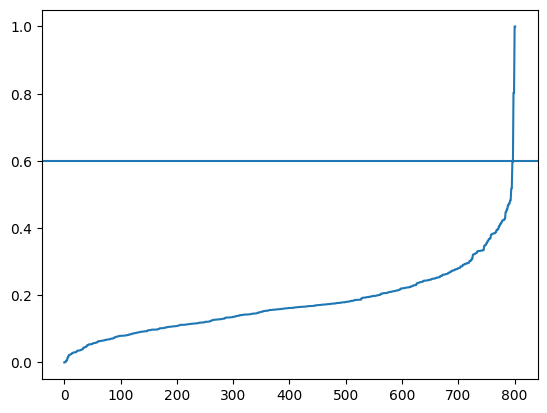

In [36]:
plt.plot(np.sort(yy1_sim_ms))
plt.axhline(0.6)

### k-motifs

In [32]:
shif_names, shif_matrixes = [], []

leno = ensemb2_config['A_H_size']

shif_idxs2 = []

idx_counter = 0
for n,m in zip(all_names, all_matrixes):
    shifm, shifn = ShiftedMotifs(m, length = leno, name = n)
    shif_names.extend(shifn)
    shif_matrixes.extend(shifm)

    lenoz = len(shifn)

    shif_idxs2.append(np.arange(lenoz) + idx_counter)

    idx_counter += lenoz

print(len(shif_matrixes), len(shif_names))

5702 5702


In [33]:
#yy1_kppm_idxs = [ix for ix, x in enumerate(shif_names) if 'YY1' in x]

sw = True
uniq = True
ru = True #RECIPEUC

hys_args = {'sub_model': 'A', 'joint': ensemb2_config['A_joint'], 
            'random_seqs': 10000, 'unique': uniq, 
            'scoreweight': sw, 
            'recipeuc': ru, #########
            'batchsize': 8192}

# shif_scores = []

# for ip, ppm in enumerate(shif_matrixes): #enumerate([shif_matrixes[x] for x in yy1_kppm_idxs]):
#     shif_scores.append(Oys_ScorePPM_vX2(pn_ensemb2_mod, ppm, **hys_args))
#     if ip % 10 == 0: print(f'finished {ip}')

# shif_scores = np.squeeze(np.stack(shif_scores))

# PickleDump(shif_scores, bestloc2 + 'shif_scores')

In [34]:
shif_scores = PickleLoad(bestloc2 + 'shif_scores')

mino, maxo = (np.round(f(shif_scores),4) for f in [np.min, np.max])
print(mino, maxo)

pdo = pd.DataFrame(data = np.array(shif_names), columns = ['k-Motif'])

poss = np.arange(len(shif_scores.T))
pdo[poss] = shif_scores

shif_scores_maxs2 = np.max(shif_scores, axis = 1)
sorto = np.argsort(np.abs(shif_scores_maxs2))[::-1]

pdx = pdo.iloc[sorto] #.iloc[:40]

pdx_sty = pdx.style.format(precision=3).background_gradient(cmap = 'Grays', axis = None, subset = poss,
                                                            vmin = mino, vmax = maxo)
# pdx_sty.to_excel(bestloc2 + 'k-motifs.xlsx')

-0.0006 0.0288


#### Summarized Motifs

In [35]:
sum_motifs_score = SummarizedPatterns(shif_scores, shif_idxs2, 
                                      k_size = leno, seq_len=500, pos_reso = 50,
                                      center = True, pat_sizes = all_motif_lengths)

sum_motifs_score_shared = SharedContribs(sum_motifs_score, lengths = motif_lengths, k_size = leno,
                                         center = True)                                         

sum_motifs_absmax = np.max(np.abs(sum_motifs_score_shared), axis = -1)


sorto = np.argsort(sum_motifs_absmax)[::-1]
thresh = 0.01
ot = np.where(sum_motifs_absmax.reshape(-1) > thresh)[0]
filt = np.array([s for s in sorto if s in ot])

sum_motifs_score_filt, all_names_filt = [x[filt] for x in [sum_motifs_score_shared, np.array(all_names)]]

In [51]:
sxpd = pd.DataFrame(data = sum_motifs_score_shared, columns = np.arange(500))
sxpd.index = motif_names_filt
sxpd.index.name = 'Motif'

sxpd = sxpd.iloc[sorto]

sxpd.to_excel(bestloc2 + 'sxpd.xlsx')

In [49]:
sxpd.iloc[sorto]

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
Motif,,,,,,,,,,,,,,,,,,,,,
TYY1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.018399,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZFP42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010392,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
HXB4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001427,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
THAP1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOX17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001116,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZNF85,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000058,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
IRF8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000022,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
P53,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000078,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch
from matplotlib.font_manager import FontProperties

def LogoPlot(arr, ax = None, figsize = (5,5), fontsize = 10, 
             ylabel = 'Proportion', xticks = True): 

    #########################################

    fp = FontProperties(weight="bold") 
    globscale = 1.35
    LETTERS = { "T" : TextPath((-0.32, 0), "T", size=1, prop=fp),
                "G" : TextPath((-0.45, 0), "G", size=1, prop=fp),
                "A" : TextPath((-0.4, 0), "A", size=1, prop=fp),
                "C" : TextPath((-0.4, 0), "C", size=1, prop=fp) }
    COLOR_SCHEME = {'G': 'orange', 'A': 'darkgreen', 'C': 'blue', 'T': 'red'}

    def letterAt(letter, x, y, yscale=1, ax=None):
        text = LETTERS[letter]

        t = mpl.transforms.Affine2D().scale(1*globscale, yscale*globscale) + \
            mpl.transforms.Affine2D().translate(x,y) + ax.transData
        p = PathPatch(text, lw=0, fc=COLOR_SCHEME[letter],  transform=t)
        if ax != None:
            ax.add_artist(p)
        return p

    #########################################

    if ax is None: fig, ax = plt.subplots(figsize = figsize)

    lets = np.array(['A', 'C', 'G', 'T'])

    x = 1
    maxi = 0
    for scores in arr:
        y = 0
        sor = np.argsort(scores)
        scores_sortd, lets_sorted = [jk[sor] for jk in [scores, lets]]
        for base, score in zip(lets_sorted, scores_sortd):
            letterAt(base, x,y, score, ax)
            y += score
        x += 1
        maxi = max(maxi, y)

    ax.set_xlim((0, x))
    ax.set_ylim((0, maxi))
    ax.set_ylabel(ylabel, fontsize = fontsize)
    if xticks: 
        ax.set_xticks(range(1,x))
        ax.tick_params(axis='x', labelsize=fontsize)
    ax.tick_params(axis='y', labelsize=fontsize)

    return ax

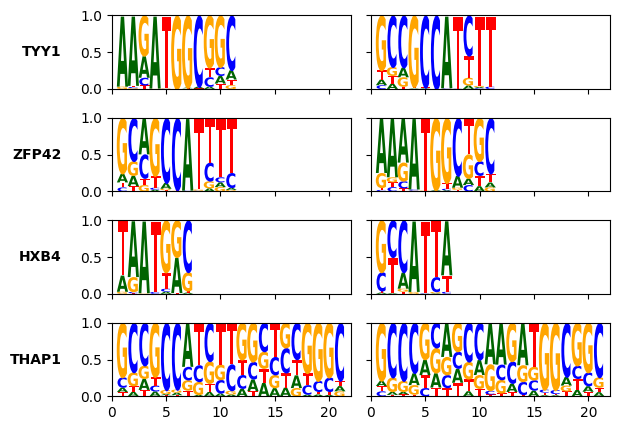

In [26]:
motifs_display = [[motif_matrixes[f], np.flip(motif_matrixes[f], axis = (0,1))] for f in filt]
motif_maxsize = np.max([len(m) for mo in motifs_display for m in mo ])


MultiPlot(motifs_display, plt_mode = [LogoPlot, {'xticks': False, 'ylabel': None}],
          multi = True, paired = True, transpose = True,
          rowtitle = all_names_filt, rowtitle_rotation = False,
          sharex = True, sharey = True, 
          figsize = (motif_maxsize * 0.3, len(filt) * 1.1));

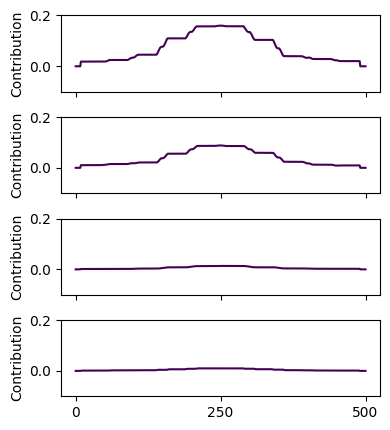

In [27]:
mp_args = {'multi': True, 'paired': False, 'transpose': False, 
           'columntitle': None,
           'rowtitle': None, 
           'rowtitle_rotation': False,
           'figsize': (4, len(filt) * 1.1), 'fontsize': 10,
           'sharey': True, 'sharex': True}

nucseqlen = 500

line_args = {'xticklabel': [0, nucseqlen // 2, nucseqlen], 'bounds': [-0.1, 0.2],
             'xlabel': None, 'ylabel': 'Contribution'}


MultiPlot(sum_motifs_score_filt, **mp_args, customgrid=None,
                 plt_mode = [LinePlot, line_args]);

## Histones

In [52]:
ensemb2_histones = [histones[9]]

his_signals = dx2_sel
H_size = ensemb2_config['B_H_size']

num_clust = 500

osc_args = {'H_size': ensemb2_config['B_H_size'],
            'num_clusters': num_clust, 'sample': 1000000}

oss_args = {#'H_size': ensemb2_config['B_H_size'], 
            'sub_model': 'B', 'joint': ensemb2_config['B_joint'], 
            'chunk': True, 'batchsize': 63768}

In [53]:
# his_signals_win = TridentWindow(his_signals, H_size)
# PickleDump(his_signals_win, bestloc2 + 'his_signals_win')

# his_signals_clustered = Oys_SigCluster(his_signals, **osc_args)
# PickleDump(his_signals_clustered,  bestloc2 + 'his_signals_clustered')

# his_signals_win = PickleLoad(bestloc2 + 'his_signals_win')
# his_signals_clustered = PickleLoad(bestloc2 + 'his_signals_clustered')
# his_signals_clustered_ref = np.stack([RefineClusters(his_signals_win[:, c, :, 0], his_signals_clustered[:, c]) 
#                                       for c in np.arange(len(ensemb2_histones))], axis = 1)
# PickleDump(his_signals_clustered_ref, bestloc2 + 'his_signals_clustered_ref')

In [54]:
# #SUB SAMPLING FOR STORAGE PURPOSES. ############ NOT DOING THIS ANYMORE

# his_signals_win = PickleLoad(bestloc2 + 'his_signals_win')
# his_signals_clustered_ref = PickleLoad(bestloc2 + 'his_signals_clustered_ref')

# his_subsamp = SubSample_Random(his_signals_clustered_ref, proportion = 0.5)
# PickleDump(his_subsamp, bestloc2 + 'his_subsamp')

# his_signals_win_subsamp = his_signals_win[his_subsamp]
# PickleDump(his_signals_win_subsamp, bestloc2 + 'his_signals_win_subsamp')

# his_signals_clustered_ref_subsamp =  his_signals_clustered_ref[his_subsamp]
# PickleDump(his_signals_clustered_ref_subsamp, bestloc2 + 'his_signals_clustered_ref_subsamp')

In [55]:
# his_signals_win = PickleLoad(bestloc2 + 'his_signals_win')
# his_signals_contrib = Oys_ScoreSignals(pn_ensemb2_mod, his_signals_win, **oss_args)
# PickleDump(his_signals_contrib, bestloc2 + 'ensemble_' + 'his_signals_contrib')

# his_signals_win = PickleLoad(bestloc2 + 'his_signals_win')
# his_signals_clustered_ref = PickleLoad(bestloc2 + 'his_signals_clustered_ref')
# his_signals_contrib = PickleLoad(bestloc2 + 'ensemble_' + 'his_signals_contrib') ###################
# his_signals_centroids = Oys_SigCentroids(his_signals_win, his_signals_contrib, 
#                                          his_signals_clustered_ref, weighted = True)
# PickleDump(his_signals_centroids,  bestloc2 + 'ensemble_' + 'his_signals_centroids')

In [56]:
his_signals_centroids = PickleLoad(bestloc2 + 'ensemble_' + 'his_signals_centroids')

cents, cents_contribs = his_signals_centroids
cents_contribs = np.squeeze(np.vstack(cents_contribs))

his_names = np.hstack([np.repeat(h, len(cents[ih])) for ih, h in enumerate(ensemb2_histones)])
his_clusts = np.hstack([np.arange(len(cents[ih])) + 1 for ih, h in enumerate(ensemb2_histones)])

In [57]:
centos = np.squeeze(np.vstack(cents))

# means = np.mean(centos, axis = 1) ######### NOT DOING THIS ANYMORE
# centos_norm = centos / means.reshape(-1, 1)

mino, maxo = (f(centos) for f in [np.min, np.max])
print(mino, maxo)

k_names = np.arange(ensemb2_config['B_H_size']) + 1

pdo = pd.DataFrame(data = centos)
pdo.columns = k_names
pdo['Histone'] = his_names
pdo['Cluster'] = his_clusts

pdo = pdo.set_index(['Histone', 'Cluster'])

#pdo['Mean'] = means

pdx = pdo#.iloc[sorto].iloc[:50]

pdx_sty = pdx.style.format(precision=3).background_gradient(cmap = 'Greys', axis = None, 
                                                            subset = k_names, 
                                                            vmin = mino, vmax = maxo)
# pdx_sty = pdx_sty.background_gradient(cmap = 'Greys', axis = None, 
#                                                             subset = 'Mean')

pdx_sty

0.010506925 0.8467542


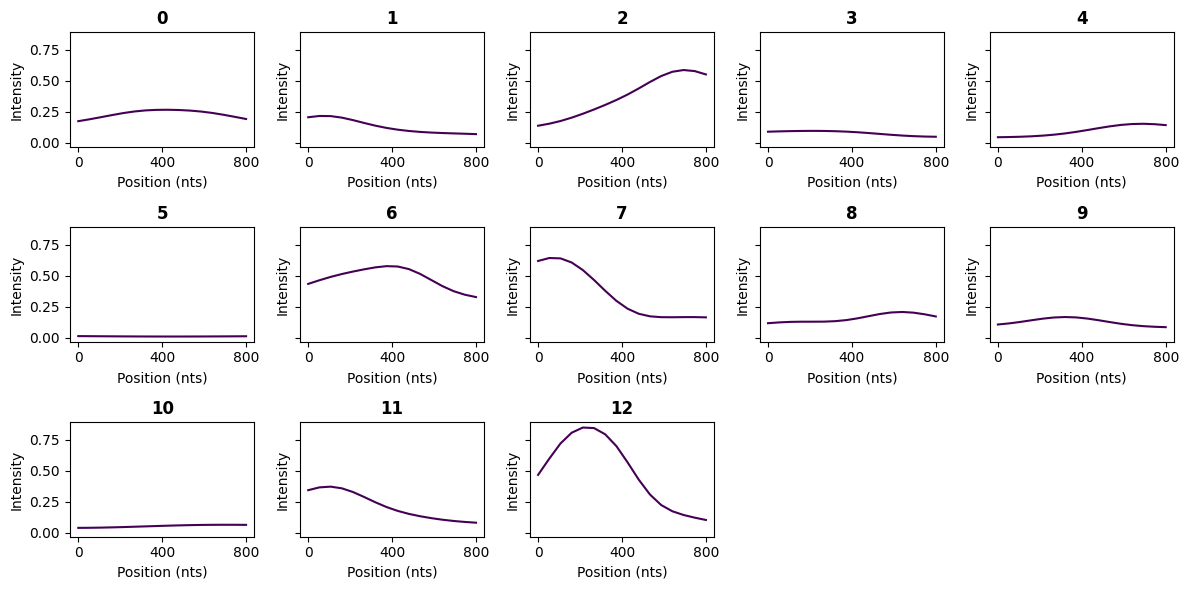

In [58]:
mp_clust_args = {'multi': True, 'paired': False, 'transpose': False, 
           'columntitle': None,
           'rowtitle': None, 'rowtitle_rotation': True,
           'figsize': (12, 6), 'fontsize': 10,
           'sharey': True, 'sharex': False, 


           'indiv_args': {'suptitle': np.arange(len(centos))}}


lenhis = ensemb2_config['B_H_size']
resohis = 50
totalhis = resohis*lenhis

line_args = {'xticklabel': [0, totalhis // 2, totalhis], 
             'xlabel': 'Position (nts)', 'ylabel': 'Intensity'}


MultiPlot(centos, **mp_clust_args, customgrid=(3, 5),
                 plt_mode = [LinePlot, line_args]);

In [59]:
cents_contribs_exp = ExpandedContribs(cents_contribs, 80, H_size, center = True)

cents_contribs_max = np.max(np.abs(cents_contribs_exp), axis = -1).reshape(-1)

sorto = np.argsort(cents_contribs_max)[::-1]
ot = np.where(cents_contribs_max.reshape(-1) > 0.01)[0]
filt = np.array([s for s in sorto if s in ot])

cents_contribs_filt, centos_filt = [x[filt] for x in [cents_contribs_exp, centos]]

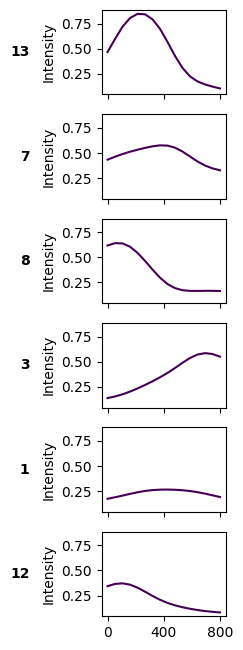

In [60]:
mp_clust_top_args = mp_clust_args.copy()
mp_clust_top_args.update({'figsize': (1.5 + 1, len(filt) * 1.1), 
                          'indiv_args': None, # {'suptitle': filt+1}, 
                          'rowtitle': filt+ 1, 'rowtitle_rotation': False, 
                          'sharey': True, 'sharex': True})

line_args2 = line_args.copy()
line_args2.update({'suptitle': None, 'xlabel': None})

MultiPlot(centos_filt, **mp_clust_top_args, #customgrid=(2, 3),
                 plt_mode = [LinePlot, line_args2]);

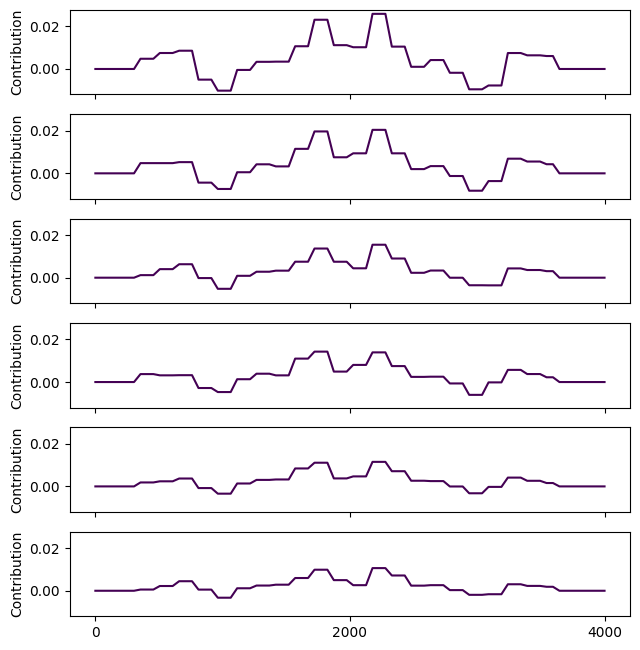

In [61]:
mp_contrib_top_args = mp_clust_top_args.copy()
mp_contrib_top_args.update({'figsize': (1.5 + 5, len(filt) * 1.1), 
                          'indiv_args': None, # {'suptitle': filt+1}, 
                          'rowtitle': None, 'rowtitle_rotation': False, 
                          'sharey': True, 'sharex': True})

line_args2 = line_args.copy()
line_args2.update({'xticklabel': [0, 4000 // 2, 4000], 'ylabel': 'Contribution',
    'suptitle': None, 'xlabel': None})

MultiPlot(cents_contribs_filt, **mp_contrib_top_args, #customgrid=(2, 3),
                 plt_mode = [LinePlot, line_args2]);

In [64]:
mino, maxo = (f(cents_contribs) for f in [np.min, np.max])
print(mino, maxo)

his_clust_contribs_maxs = np.max(cents_contribs, axis = -1).reshape(-1)

sorto = np.argsort(his_clust_contribs_maxs)[::-1]


pdo = pd.DataFrame(data = cents_contribs,
                   columns = np.arange(len(cents_contribs.T)) + 1)
pdo['Histone'] = his_names
pdo['Cluster'] = his_clusts

pdo = pdo.set_index(['Histone', 'Cluster'])

pdx = pdo.iloc[sorto]#.iloc[:50]

pdx_sty = pdx.style.format(precision=3).background_gradient(cmap = 'Greys', axis = None, 
                                                            vmin = mino, vmax = maxo)
pdx_sty

-0.010181527 0.025899848


In [26]:
cents_contribs_pos = cents_contribs / ensemb2_config['B_C_pos']

mino, maxo = (f(cents_contribs_pos) for f in [np.min, np.max])
print(mino, maxo)

his_clust_contribs_maxs = np.max(cents_contribs_pos, axis = -1).reshape(-1)

sorto = np.argsort(his_clust_contribs_maxs)[::-1]


pdo = pd.DataFrame(data = cents_contribs_pos,
                   columns = np.arange(len(cents_contribs_pos.T)))
pdo['Histone'] = his_names
pdo['Cluster'] = his_clusts

pdo = pdo.set_index(['Histone', 'Cluster'])

pdx = pdo.iloc[sorto]#.iloc[:50]

pdx_sty = pdx.style.format(precision=3).background_gradient(cmap = 'Greys', axis = None, 
                                                            vmin = mino, vmax = maxo)
pdx_sty

-0.012655093 0.028148001


## All k-mers of all sequences

In [37]:
def Oys_KmerSeq_vX(model, inp, 
                   H_size = 10, pos_res = 1, 
                   sub_model = None, joint = False,
                   batchsize = 256):
    
    # trying to get the k-mer contributions of the sequences 

    if isinstance(model, list) == False: model = [model]

    shapo = inp.shape

    lk = shapo[0]
    fullbatches = lk // batchsize
    rem = lk % batchsize

    afke = shapo[2] - H_size + 1

    all_fins = []

    for mo in model: 

        modx = LoadTorch(mo) if isinstance(mo, str) else mo

        with torch.no_grad(): 
            modx.eval()

            pado = getattr(modx, 'C' + sub_model).padding[0]

            Dweight = getattr(modx, 'D' + sub_model)[0].weight
            Dweight = torch.unsqueeze(Dweight, 0)
            Dweight_exp = torch.repeat_interleave(Dweight, pos_res, dim=-2)
            Dweight_exp = Dweight_exp[:, :, :, pado:afke-pado]
            #print(Dweight_exp.shape)

            fins = []
            for fb in np.arange(fullbatches + (rem > 0)):
                fo = fb*batchsize

                x = inp[fo:fo + batchsize]
                x = torch.FloatTensor(x).to(device)

                if joint: x = getattr(modx, 'Reflect' + sub_model)(x)
        
                x = getattr(modx, 'H' + sub_model)(x)
                x = getattr(modx, 'O' + sub_model)(x)

                ################## CHECK #########################

                yo = getattr(modx, 'C' + sub_model)(x)
                yo = getattr(modx, 'D' + sub_model)(yo)
                #print(yo.reshape(-1))

                ####################################

                x = torch.unsqueeze(x, 1)
                x = (x * Dweight_exp)

                x1 = x[:, :, :, :pos_res * (afke // pos_res)] / 3
                x2 = x[:, :, :, -(afke % pos_res):] / (afke % pos_res)
                x3 = torch.concat([x1, x2], dim = 3)
                
                #print(torch.sum(x3, dim = (2, 3)).reshape(-1)) # CHECK WITH "YO" 

                fins.append(torch.sum(x3, dim = (1, 2, 4)).cpu().detach().numpy())
            
            fins = np.vstack(fins)
        all_fins.append(fins)           

    return np.stack(all_fins)

In [43]:
hiskmers_contrib = Oys_KmerSeq_vX(pn_ensemb2_mod, dx2_sel, 
                                  H_size = ensemb2_config['B_H_size'], 
                                  pos_res = ensemb2_config['B_C_pos'], 
                                  sub_model = 'B', joint = False,
                                  batchsize = 256)

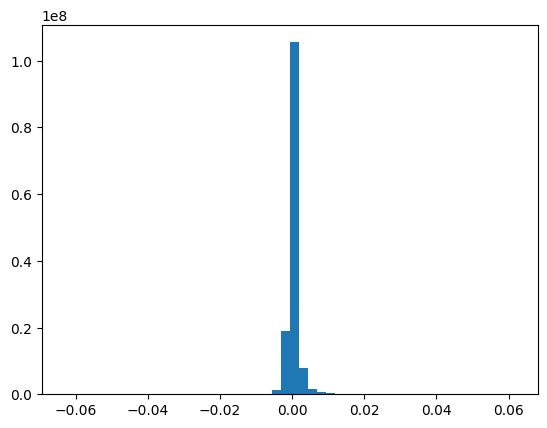

In [45]:
plt.hist(hiskmers_contrib.reshape(-1), 50);

In [52]:
hiskmers_contrib_avg = np.mean(hiskmers_contrib, axis = 0)
hiskmesr_contrib_avg_flat = hiskmers_contrib_avg.reshape(-1)

hiskmer_thresh = 0.01

hiskmers_top = np.where(np.abs(hiskmesr_contrib_avg_flat) > hiskmer_thresh)[0]
hiskmers_top

array([   2624,    2625,    2626, ..., 9732292, 9732293, 9735021])

In [58]:
hiskmers_top[:100]

array([ 2624,  2625,  2626,  2627,  2628,  2629,  3602,  3603,  3604,
        3928,  3929,  4509,  4510,  4511,  4512,  4513,  4514,  4769,
        4770,  4771,  4772,  4773,  4774, 13934, 13935, 13936, 13937,
       13938, 13939, 16407, 16408, 16409, 16416, 16417, 16418, 16859,
       16860, 16861, 16862, 16863, 16864, 22721, 22722, 22723, 26167,
       26168, 29026, 29027, 29028, 29278, 29279, 31614, 31615, 31616,
       31617, 31618, 31619, 32592, 32593, 32798, 38244, 38245, 38246,
       38247, 38248, 38249, 42276, 42277, 42278, 42279, 42351, 42352,
       47604, 47605, 47606, 47607, 47608, 47609, 47616, 47617, 47618,
       48126, 48127, 48128, 48129, 53064, 53065, 53067, 53194, 53195,
       53196, 53197, 53198, 53199, 53206, 53207, 53208, 54429, 54430,
       54431])

In [53]:
his_signals_win = PickleLoad(bestloc2 + 'his_signals_win')

In [54]:
his_signals_win.shape

(9750000, 1, 16, 1)

In [55]:
hiskmesr_contrib_avg_flat.shape

(9750000,)

In [46]:
np.sum(np.abs(hiskmers_contrib) > 0.01)

387614

In [47]:
np.product([14, 150000,65])

136500000

In [48]:
np.sum(np.mean(np.abs(hiskmers_contrib), axis = 0) > 0.01)

19827

In [50]:
387614 // 14

27686

In [130]:
pn_ensemb2_mod

['./yy1_oyster/xpHIS/0/7/0_0_Mod.pt',
 './yy1_oyster/xpHIS/0/7/0_1_Mod.pt',
 './yy1_oyster/xpHIS/0/7/0_2_Mod.pt',
 './yy1_oyster/xpHIS/0/7/0_3_Mod.pt',
 './yy1_oyster/xpHIS/0/7/0_4_Mod.pt',
 './yy1_oyster/xpHIS/0/7/0_5_Mod.pt',
 './yy1_oyster/xpHIS/0/7/0_6_Mod.pt',
 './yy1_oyster/xpHIS/0/7/0_7_Mod.pt',
 './yy1_oyster/xpHIS/0/7/0_8_Mod.pt',
 './yy1_oyster/xpHIS/0/7/0_9_Mod.pt',
 './yy1_oyster/xpHIS/0/7/0_10_Mod.pt',
 './yy1_oyster/xpHIS/0/7/0_11_Mod.pt',
 './yy1_oyster/xpHIS/0/7/0_12_Mod.pt',
 './yy1_oyster/xpHIS/0/7/0_14_Mod.pt']

In [125]:
ensemb2_config['B_C_pos']

3

In [8]:
sh_args = {'bins': bins, 'switch': True, 
           'pointsize': 3,
           'alpha': 0.15, 
           'sharebounds': True, 
           'boundspad': 0.05,
           'line': True, 

           'color': 'rebeccapurple', 
           
           'xlabel': 'YY1 Intensity',
           'ylabel': 'Prediction'}

mp_args = {'multi': True, 'paired': False, 'transpose': True, 
           'columntitle': divset,
           'rowtitle': None, 'rowtitle_rotation': True,
           'figsize': (12, 3.5), 'fontsize': 10,
           'sharey': True, 'sharex': True}

bp_args2 = {'xlabel': 'YY1 Intensity Bins', 
            'labelheight': False, 
            'alpha': 0.5}

pbp_args = {'bp_args': bp_args2,
            'ylabels': ['DRMSE', 'Proportion'], 

            'colors': ['darkturquoise', 'tan', 'darkgreen', 'firebrick'], 
            'linewidth': 1, 'linestyle': '--', 
            'legend': False, 'xtick_rotation': 0} 

In [9]:
def CM2PFM(CM): 
    sums = np.sum(CM, axis = 1).reshape(-1, 1)
    return CM / sums

def kmersFromPPM(ppm, num = 10000, unique = False):

    lets = [np.random.choice(['A', 'C', 'G', 'T'], 
                                     size = num, replace = True, 
                                     p = px) for px in ppm]
    
    kmers = [''.join(row) for row in np.stack(lets, axis = 1)]

    if unique: kmers = list(np.unique(kmers))
    
    return kmers

def Oys_KmerContrib_vX(model, inp,
                      sub_model = None, joint = False,
                      chunk = False): 
    
    #For no kmer associations

    if isinstance(model, str): model = LoadTorch(model)

    if sub_model is None: sub_model = ''

    shapo = inp.shape

    with torch.no_grad(): 
        model.eval()

        Dweight = getattr(model, 'D' + sub_model)[0].weight
        Dweight = torch.unsqueeze(Dweight, 0)

        x = inp
        if joint: x = getattr(model, 'Reflect' + sub_model)(x)
    
        x = getattr(model, 'H' + sub_model)(x)
    
        x = getattr(model, 'O' + sub_model)(x)
            
        x = torch.unsqueeze(x, axis = 1)
        
        #print(x.shape, Dweight.shape) ######################

        x = x * Dweight

        if chunk: 
            xshapo = x.shape
            x = x.reshape(xshapo[0], xshapo[1], shapo[1], xshapo[2] // shapo[1], *xshapo[-2:])
            x = torch.sum(x, axis = 3)
        else: 
            x = torch.sum(x, axis = -3)

        if joint: x = torch.unsqueeze(torch.mean(x, axis = -1), dim= -1)

    return x.cpu().detach().numpy()

def Oys_ScorePPM_vX2(model, ppm,
                       
                       sub_model = None, joint = False, chunk = False,

                       recipeuc = False, posres = 1,
                       
                       random_seqs = 10000, unique = True, 
                       
                       scoreweight = True, 
                       batchsize = 256):

    #generates kmers from the ppm and scores them to the final output
    # CURRENTLY ONLY SUPPORTS ONE HEADED OYSTER MODEL
    #ppm must be the same size as what the Hydra head uses 
    #can do two types of scoring: distance or new method


    # recipeuc is reciprocal euclidean distance for weighting. Or else it would do the dot product. 
    # posres is positional resolution which for oyster models we do average pooling most times so you need to divide! 

    kmers = kmersFromPPM(ppm, num = random_seqs, unique = unique)
    kmers_OHE = Seqs2OHE(kmers)

    lk = len(kmers)
    
    ####################### PWM SCORE #########################
    kmers_scored = PWMScorer(kmers_OHE, ppm, revcomp = joint, recipeuc = recipeuc).reshape(-1, 1, 1, 1) if scoreweight else 1
    print(kmers_scored.shape)

    fullbatches = lk // batchsize
    rem = lk % batchsize

    fins = []

    for fb in np.arange(fullbatches + (rem > 0)):

        fo = fb*batchsize

        batch = kmers_OHE[fo:fo + batchsize]

        if isinstance(model, list): 
            fin = []
            for m in model: 
                O = torch.FloatTensor(np.expand_dims(batch, axis = 1)).to(device)
                fin.append(Oys_KmerContrib_vX(m, O, sub_model = sub_model, joint = joint, chunk = chunk))
            fin = np.mean(np.stack(fin), axis = 0)

        else: 

            O = torch.FloatTensor(np.expand_dims(batch, axis = 1)).to(device)
            fin = Oys_KmerContrib_vX(model, O, sub_model = sub_model, joint = joint, chunk = chunk)
        
        fins.append(fin)
    
    fins = np.vstack(fins)

    #print(fins.shape, kmers_scored.shape)

    out = np.sum((fins * kmers_scored), axis = 0) / np.sum(kmers_scored) if scoreweight else np.mean(fins, axis = 0)

    return out / posres

In [10]:
def Oys_ScoreMotif_vX(model, ppm, k = None, 
                       
                       sub_model = None, joint = False, chunk = False,
                       
                       random_seqs = 10000, unique = True, 
                       scoreweight = True, 
                       batchsize = 256):

    #generates kmers from the ppm and scores them to the final output
    # CURRENTLY ONLY SUPPORTS ONE HEADED OYSTER MODEL
    #ppm must be the same size as what the Hydra head uses 
    #can do two types of scoring: distance or new method


    # USES PWM SCORE TO SIMPLIFY SHITTTTTTTTTTTTTT


    if k == None: k == len(ppm)

    if k == len(ppm): ppms = [ppm]
    else: ppms = ShiftedMotifs(ppm, k, name = None)

    #print([len(y
    # ) for y in ppms])


    all_kmers_scored = []
    all_fins = []

    for pp in ppms:
        #print(pp)

        kmers = kmersFromPPM(pp, num = random_seqs, unique = unique)
        kmers_OHE = Seqs2OHE(kmers)

        lk = len(kmers)
        pwm = CM2PWM(ppm)

        if scoreweight: 
        
            kmers_scored = PWMScorer(kmers_OHE, pwm, revcomp = False).reshape(-1, 1, 1, 1)
            all_kmers_scored.append(kmers_scored)
            #^False because only need to score the kmer produced from the ppm. 

        #print(kmers_scored.shape)

        fullbatches = lk // batchsize
        rem = lk % batchsize

        fins = []

        for fb in np.arange(fullbatches + (rem > 0)):

            fo = fb*batchsize

            batch = kmers_OHE[fo:fo + batchsize]

            if isinstance(model, list): 
                fin = []
                for m in model: 
                    O = torch.FloatTensor(np.expand_dims(batch, axis = 1)).to(device)
                    fin.append(Oys_KmerContrib_vX(m, O, sub_model = sub_model, joint = joint, chunk = chunk))
                fin = np.mean(np.stack(fin), axis = 0)

            else: 

                O = torch.FloatTensor(np.expand_dims(batch, axis = 1)).to(device)
                fin = Oys_KmerContrib_vX(model, O, sub_model = sub_model, joint = joint, chunk = chunk)
            
            fins.append(fin)
        
        fins = np.vstack(fins)
        all_fins.append(fins)
    
    all_fins = np.vstack(all_fins)
    all_kmers_scored = np.vstack(all_kmers_scored) if scoreweight else 1

    #print(all_fins.shape, all_kmers_scored.shape)

    outo = np.sum((all_fins * all_kmers_scored), axis = 0) / np.sum(all_kmers_scored)

    #print(outo.shape)

    return outo

In [ ]:
from sklearn.cluster import KMeans

def TridentWindow(inp, size): 
    ST = np.lib.stride_tricks.sliding_window_view
    winshape = (inp.shape[1], size, inp.shape[-1])
    sig_win = ST(inp, (1, *winshape))
    sig_win_rs = sig_win.reshape(-1, *winshape)
    return sig_win_rs


def Oys_ScoreSignals(model, inp, 
                     sub_model = '', joint = False, chunk = False,
                     batchsize = 256):


    #inp is a trident pack with (num, signal, length, wid) 

    #sig_win_rs = TridentWindow(inp, H_size)
    sig_win_rs = inp

    lk = len(sig_win_rs)

    fullbatches = lk // batchsize
    rem = lk % batchsize

    fins = []

    for fb in np.arange(fullbatches + (rem > 0)):

        fo = fb*batchsize

        batch = sig_win_rs[fo:fo + batchsize]

        if isinstance(model, list): 
            fin = []
            for m in model: 
                O = torch.FloatTensor(batch).to(device)
                fin.append(Oys_KmerContrib_vX(m, O, sub_model = sub_model, joint = joint, chunk = chunk))
            fin = np.mean(np.stack(fin), axis = 0)

            print(fin.dtype)
            print(fin.shape)
        
        else: 

            O = torch.FloatTensor(batch).to(device)
            fin = Oys_KmerContrib_vX(model, O, sub_model = sub_model, joint = joint, chunk = chunk)
        
        fins.append(fin)
    
    fins = np.vstack(fins)

    return fins[:, 0] # to get (number, signs, pos, 1) 

def Oys_SigCluster(inp, H_size,
                      num_clusters = 10, sample = None,
                      chunk = True, 
                      cluster_mode = [KMeans, {}]):

    if isinstance(inp, str):  sig_win_rs = se.PickleLoad(inp)
    else: sig_win_rs = TridentWindow(inp, H_size)

    num_sigs = sig_win_rs.shape[1]
    
    lk = len(sig_win_rs)

    if isinstance(sample, int): 
        rando = np.random.choice(np.arange(lk), sample, replace=False)

    if chunk: 

        clustod = []
        for i in np.arange(num_sigs):

            sig = sig_win_rs[:, i].reshape(lk, -1)
            sig_samp = sig[rando] if isinstance(sample, int) else sig

            print(sig_samp.shape)



            clust = cluster_mode[0](n_clusters = num_clusters, **cluster_mode[1])
            clust.fit(sig_samp)

            clustod.append(clust.predict(sig))

            print(f'finished: {i}')
        
        clustod = np.stack(clustod, axis = 1)
    
    return clustod



def Oys_SigCentroids(wins, contribs, clusters, weighted = True):
    #wins shape = (number, signal, k, 1)
    #contribs shape = (number, signal, pos, 1)
    #clusters shape = (number, signal) 

    #this gets the centroids and their score per position 

    #weighted is to get a weighted centroid, weighted by the DISTANCE!!!!!!!!!!!
    # p = mink distance
    num_sigs = contribs.shape[1]

    centroids_all = []
    contrib_cents_all = []

    for s in np.arange(num_sigs): 

        centroids = []
        contrib_cents = []

        clus = np.unique(clusters[:, s])

        for c in clus: 

            wino = wins[:, s][clusters[:, s] == c] #this is now (num, k, 1) 

            centroid = np.mean(wino, axis = 0) #this is now (k, 1)
            centroids.append(centroid)

            contribo = contribs[:, s][clusters[:, s] == c] #this is now (num, pos, 1) 

            if weighted: ################################ NEED TO EDIT THIS FOR THE RECEUC
                    
                scores = np.sum(wino * np.expand_dims(centroid, axis = 0), axis = (-1, -2)).reshape(-1, 1, 1)
                print(scores.shape)     
                
                contrib_cent = np.sum(contribo * scores, axis = 0) / np.sum(scores)
            
            else: 

                contrib_cent = np.mean(contribo, axis = 0)
            
            contrib_cents.append(contrib_cent)

        centroids_all.append(np.stack(centroids)) 
        contrib_cents_all.append(np.stack(contrib_cents))

    return centroids_all, contrib_cents_all

In [ ]:
def GetCentroids(signal, clusters):
    #signal is a (n, *) shape and clusters is a 1dim
    return np.stack([np.mean(signal[clusters == b], axis = 0) for b in np.unique(clusters)])


from kneed import KneeLocator

def RefineClusters(signal, clusters, return_newcents = False):
                   
    
    #uses agglomerative clsutering on centroids 

    clust1_uni = np.unique(clusters)


    cents1 = GetCentroids(signal, clusters)
    model1 = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
    model1 = model1.fit(cents1)

    kn = KneeLocator(np.arange(len(model1.distances_)), model1.distances_, curve='convex', direction='increasing')
    kno = kn.knee

    model2 = AgglomerativeClustering(distance_threshold=model1.distances_[kno], n_clusters=None)
    clust2 = model2.fit_predict(cents1) #you have a lst the length of unique clusters


    clust2_uni = np.unique(clust2)
    
    print(f'from {len(clust1_uni)} to {len(clust2_uni)}')

    clust2_sepidx = [clust1_uni[clust2 == u] for u in clust2_uni] #This now tells you which of the original clusters belongs to each new cluster 


    newclust = np.ones(len(clusters))
    for u,g in zip(clust2_uni, clust2_sepidx): 
        for h in g:
            newclust[clusters == h] = u 
    

    newcents = GetCentroids(signal, newclust)

    return (newclust, newcents) if return_newcents else newclust

# Best Models

In [13]:
from poseydon.hydra import *

pn_oys = NewFolder('yy1_oyster')

pn_bcs = NewFolder(moved + 'bcs')
bob_candict = PickleLoad(pn_bcs + 'bob_candict')

best_oyster_config = bob_candict
best_oyster_config

{'A_dim_i': (1, 500, 4),
 'B_dim_i': (11, 80, 1),
 'dim_f': (1, 1, 1),
 'A_H_grouped': False,
 'B_H_grouped': True,
 'A_doublestrand': False,
 'A_joint': True,
 'A_siamese': False,
 'A_H_size': 19,
 'A_H_filt_m': 116,
 'A_H_ns_filters': 1.152438761888373,
 'A_H_base_kernel': 8,
 'A_H_1x1': True,
 'A_C_pos': 50,
 'A_D_num_mods': 0,
 'A_D_ns_filters': 0,
 'B_doublestrand': False,
 'B_joint': False,
 'B_siamese': False,
 'B_H_size': 16,
 'B_H_filt_m': 13,
 'B_H_ns_filters': 1.0366409473566665,
 'B_H_base_kernel': 5,
 'B_H_1x1': False,
 'B_C_pos': 3,
 'B_D_num_mods': 0,
 'B_D_ns_filters': 0,
 'C_pool_func': torch.nn.modules.pooling.AvgPool2d,
 'activations': LeakyReLU(negative_slope=0.01),
 'batchnorm': None,
 'batchsize': 256,
 'learningrate': 0.001748761149653122}

In [14]:
testox = copy.deepcopy(best_oyster_config)
del testox['batchsize'], testox['learningrate'] 


Dual_Oyster_v5(**testox)

Dual_Oyster_v5(
  (ReflectA): Identity()
  (HA): Sequential(
    (0): Conv2d(1, 24, kernel_size=(8, 4), stride=(1, 1), padding=valid)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(24, 50, kernel_size=(8, 1), stride=(1, 1), padding=valid)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(50, 81, kernel_size=(5, 1), stride=(1, 1), padding=valid)
    (5): LeakyReLU(negative_slope=0.01)
  )
  (OA): Sequential(
    (0): Conv2d(81, 116, kernel_size=(1, 1), stride=(1, 1), padding=valid)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (JA): Identity()
  (CA): AvgPool2d(kernel_size=(50, 1), stride=(50, 1), padding=(9, 0))
  (DA): Sequential(
    (0): Conv2d(116, 1, kernel_size=(10, 1), stride=(1, 1), padding=valid, bias=False)
  )
  (ReflectB): Identity()
  (HB): Sequential(
    (0): Conv2d(11, 33, kernel_size=(5, 1), stride=(1, 1), padding=valid, groups=11)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(33, 66, kernel_size=(5, 1), stride=(1, 1), padding=valid, groups=11)

In [15]:
xp, xp_unit = '6', 2
bestloc = NewFolder(moved + 'xp' + str(xp))

ob_ensemb = PickleLoad(bestloc + 'xp' + str(xp) + '_mets_ensemb')

ob_topreps = PickleLoad(bestloc + 'xp' + str(xp) + '_topreps')[xp_unit]

pn_ob_all_preds, pn_ob_all_mod = [[bestloc + str(xp_unit) + '/0_'+ str(b) + x for b in ob_topreps] for x in ['_preds.p',  '_Mod.pt']]

# ob_mod = LoadTorch(pn_ob_mod)
# print(ob_mod)

In [16]:
xoxo = LoadTorch(pn_ob_all_mod[0])

count_parameters(xoxo)

54205

## Determinants

In [17]:
# deter_seq = np.mean(np.stack([FeatExtract(bestloc + str(xp_unit) + '/0_'+ str(b) + '_Mod.pt', 
#                          'DA', [dx1, dx2], batchsize = 512) for b in ob_topreps]), axis = 0)

# deter_epi = np.mean(np.stack([FeatExtract(bestloc + str(xp_unit) + '/0_'+ str(b) + '_Mod.pt', 
#                          'DB', [dx1, dx2], batchsize = 512) for b in ob_topreps]), axis = 0)

# PickleDump([deter_seq, deter_epi], moved + 'ensemble_' + 'deters')

<Axes: xlabel='Sequence Contribution', ylabel='Histone PTM Contribution'>

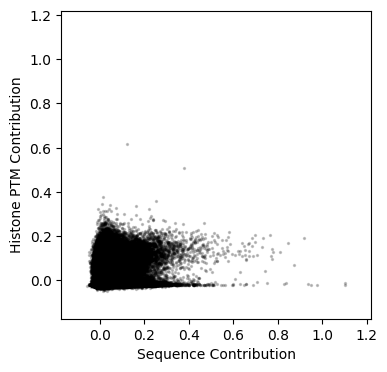

In [16]:
deter_seq, deter_epi = PickleLoad(moved + 'ensemble_' + 'deters')

ScaPlot([x.reshape(-1) for x in [deter_seq, deter_epi]], 
        fontsize = 10, figsize = (4,4), boundspad = 0.1, 
        alpha = 0.2, pointsize= 2, color = 'Black', 
        xlabel = 'Sequence Contribution', ylabel = 'Histone PTM Contribution', sharebounds = True)

In [18]:
deters_prop = np.stack([(np.abs(x)/ (np.abs(deter_epi)+ np.abs(deter_seq))).reshape(-1) 
                        for x in [deter_seq, deter_epi]])

biny = tri_tpacks[3].reshape(-1)

deters_props_bin_means = [np.array(BinFunc(x, biny, mode = [np.mean, {}])) for x in deters_prop]
deters_props_bin_stds = [np.array(BinFunc(x, biny, mode = [np.std, {}])) for x in deters_prop]

deters_props_binmeans_means = [np.mean(x) for x in deters_props_bin_means]


[0.547071, 0.45292908]


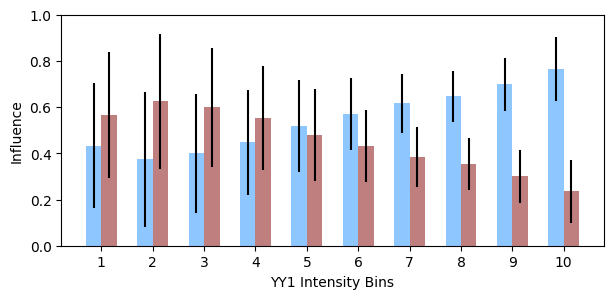

In [19]:
bp_argsX2 = {
            'xlabel': 'YY1 Intensity Bins',
            'ylabel': 'Influence',
            'group': ['DNA Seq.', 'Histone PTM'], 'legend': False,
            'color': ['dodgerblue', 'maroon'],
            'alpha': 0.5, 'width': 0.3, 'bounds': (0, 1), 'figsize': (7,3), 
            'labelheight': False, 
            'yerr': deters_props_bin_stds}

ax = BarPlot([np.arange(bins) + 1, deters_props_bin_means],
                   **bp_argsX2)

# ax.axhline(deters_props_binmeans_means[0], ls = '--', color = 'dodgerblue')
# ax.axhline(deters_props_binmeans_means[1], ls = '--', color = 'indianred')
#ax.axhline(0.5, ls = '--', color = 'black')

print(deters_props_binmeans_means)

In [20]:
deters_bin_means = [np.array(BinFunc(x, biny, mode = [np.mean, {}])) for x in [deter_seq, deter_epi]]
deters_bin_std = [np.array(BinFunc(x, biny, mode = [np.std, {}])) for x in [deter_seq, deter_epi]]

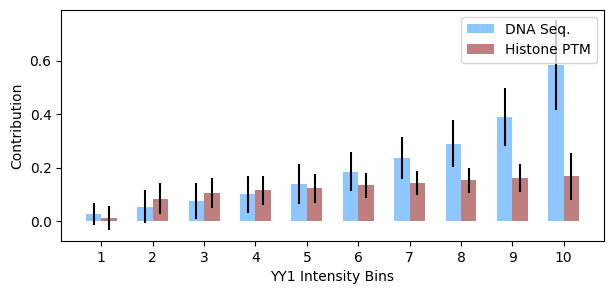

In [21]:
bp_argsX2 = {
            'xlabel': 'YY1 Intensity Bins',
            'ylabel': 'Contribution',
            'group': ['DNA Seq.', 'Histone PTM'], 'legend': True,
            'color': ['dodgerblue', 'maroon'],
            'alpha': 0.5, 'width': 0.3, 'bounds': None, 'figsize': (7, 3), 
            'labelheight': False, 
            'yerr': deters_bin_std}

ax = BarPlot([np.arange(bins) + 1, deters_bin_means],
                   **bp_argsX2)


## Motifs

In [22]:
human_core_motifs = '../../Essentials/motif_databases/HUMAN/HOCOMOCOv11_core_HUMAN_mono_meme_format.meme'

name_idx = 1
all_names, all_matrixes = MEME2Motifs(human_core_motifs, name_idx = name_idx)

all_names_filt = [a.split('_HUMAN')[0] for a in all_names]
all_names_filt[:10]

['AHR',
 'AIRE',
 'ALX1',
 'ANDR',
 'AP2A',
 'AP2B',
 'AP2C',
 'ARI5B',
 'ARNT',
 'ASCL1']

(array([12., 66., 94., 39., 52., 31., 17., 56., 22., 12.]),
 array([ 6. ,  7.7,  9.4, 11.1, 12.8, 14.5, 16.2, 17.9, 19.6, 21.3, 23. ]),
 <BarContainer object of 10 artists>)

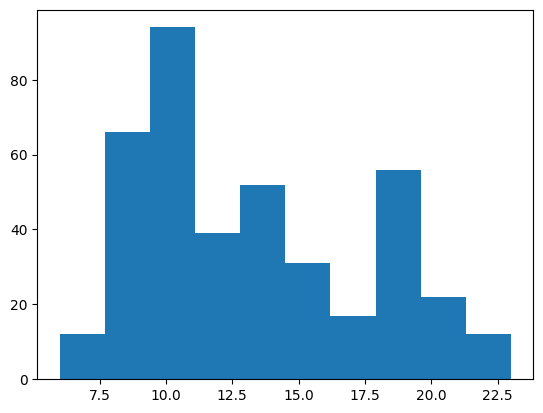

In [23]:
plt.hist([len(x) for x in all_matrixes])

In [24]:
yy1_motif_idx = all_names_filt.index('TYY1')

# yy1_motif = all_matrixes[yy1_motif_idx]

# PickleDump(yy1_motif, mainfolder + "yy1_motif")

# LogomakerFromNumpy(yy1_motif)

### k-motifs

In [25]:
shif_names, shif_matrixes = [], []

leno = best_oyster_config['A_H_size']

shif_idxs2 = []

idx_counter = 0
for n,m in zip(all_names_filt, all_matrixes):
    shifm, shifn = ShiftedMotifs(m, length = leno, name = n)
    shif_names.extend(shifn)
    shif_matrixes.extend(shifm)

    lenoz = len(shifn)

    shif_idxs2.append(np.arange(lenoz) + idx_counter)

    idx_counter += lenoz

print(len(shif_matrixes), len(shif_names))

2851 2851


In [45]:
best_oyster_config

{'A_dim_i': (1, 500, 4),
 'B_dim_i': (11, 80, 1),
 'dim_f': (1, 1, 1),
 'A_H_grouped': False,
 'B_H_grouped': True,
 'A_doublestrand': False,
 'A_joint': True,
 'A_siamese': False,
 'A_H_size': 19,
 'A_H_filt_m': 116,
 'A_H_ns_filters': 1.152438761888373,
 'A_H_base_kernel': 8,
 'A_H_1x1': True,
 'A_C_pos': 50,
 'A_D_num_mods': 0,
 'A_D_ns_filters': 0,
 'B_doublestrand': False,
 'B_joint': False,
 'B_siamese': False,
 'B_H_size': 16,
 'B_H_filt_m': 13,
 'B_H_ns_filters': 1.0366409473566665,
 'B_H_base_kernel': 5,
 'B_H_1x1': False,
 'B_C_pos': 3,
 'B_D_num_mods': 0,
 'B_D_ns_filters': 0,
 'C_pool_func': torch.nn.modules.pooling.AvgPool2d,
 'activations': LeakyReLU(negative_slope=0.01),
 'batchnorm': None,
 'batchsize': 256,
 'learningrate': 0.001748761149653122}

In [46]:
#yy1_kppm_idxs = [ix for ix, x in enumerate(shif_names) if 'YY1' in x]

sw = True
uniq = True
ru = True #RECIPEUC

hys_args = {'sub_model': 'A', 'joint': best_oyster_config['A_joint'], 
            'random_seqs': 10000, 'unique': uniq, 
            'scoreweight': sw, 
            'recipeuc': ru, 'posres': best_oyster_config['A_C_pos'],##############################
            'batchsize': 8192}

# shif_scores = []

# for ip, ppm in enumerate(shif_matrixes): #enumerate([shif_matrixes[x] for x in yy1_kppm_idxs]):
#     shif_scores.append(Oys_ScorePPM_vX2(pn_ob_all_mod, ppm, **hys_args))
#     if ip % 10 == 0: print(f'finished {ip}')

# shif_scores = np.squeeze(np.stack(shif_scores))

# PickleDump(shif_scores, moved + 'ensemble_' + 'shif_scores')

In [48]:
shif_scores = PickleLoad(moved + 'ensemble_' + 'shif_scores')

In [49]:
shif_scores.shape

(2851, 10)

In [50]:
mino, maxo = (np.round(f(shif_scores),4) for f in [np.min, np.max])
print(mino, maxo)

pdo = pd.DataFrame(data = np.array(shif_names), columns = ['k-Motif'])

poss = np.arange(len(shif_scores.T))
pdo[poss] = shif_scores

shif_scores_maxs2 = np.max(shif_scores, axis = 1)
sorto = np.argsort(np.abs(shif_scores_maxs2))[::-1]

pdx = pdo.iloc[sorto] #.iloc[:40]

pdx_sty = pdx.style.format(precision=3).background_gradient(cmap = 'Grays', axis = None, subset = poss,
                                                            vmin = mino, vmax = maxo)
# pdx_sty

-0.0006 0.0331


In [51]:
pdx_sty.to_excel("k-motifs.xlsx")

#### Summarised Motifs

In [52]:
motif_scores = np.stack([np.sum(shif_scores[ido], axis = 0) for ido in shif_idxs2])
motif_scores.shape

(401, 10)

In [53]:
mino, maxo = (np.round(f(motif_scores),4) for f in [np.min, np.max])
print(mino, maxo)

pdo = pd.DataFrame(data = np.array(all_names_filt), columns = ['Motif'])

poss = np.arange(len(shif_scores.T))
pdo[poss] = motif_scores

shif_scores_maxs2 = np.max(np.abs(motif_scores), axis = 1)
sorto = np.argsort(shif_scores_maxs2)[::-1]

pdx = pdo.iloc[sorto] #.iloc[:40]

pdx_sty = pdx.style.format(precision=3).background_gradient(cmap = 'Grays', axis = None, subset = poss,
                                                            vmin = mino, vmax = maxo)
pdx_sty.to_excel("motifs.xlsx")

pdx_sty2 = pdx.iloc[:40].style.format(precision=3).background_gradient(cmap = 'Grays', axis = None, subset = poss,
                                                            vmin = mino, vmax = maxo)
pdx_sty2

-0.0025 0.151


,Motif,0,1,2,3,4,5,6,7,8,9
328,TYY1,0.016,0.015,0.036,0.100,0.147,0.151,0.094,0.029,0.022,0.020
344,ZFP42,0.008,0.010,0.016,0.047,0.083,0.084,0.060,0.018,0.008,0.010
128,HXB4,0.001,0.001,0.002,0.007,0.012,0.013,0.007,0.003,0.001,0.002
324,THAP1,0.001,0.001,0.003,0.007,0.010,0.011,0.007,0.003,0.002,0.001
281,SOX17,0.001,0.001,0.002,0.005,0.010,0.010,0.007,0.002,0.001,0.002
260,RFX3,-0.000,0.000,0.001,0.004,0.008,0.008,0.005,0.002,0.001,0.001
37,CREB1,0.000,0.000,0.001,0.003,0.006,0.007,0.003,0.001,0.001,0.001
259,RFX2,0.000,0.000,0.001,0.003,0.006,0.006,0.004,0.001,0.000,0.001
11,ATF2,0.000,0.000,0.000,0.003,0.005,0.006,0.003,0.001,0.000,0.001
131,HXC9,0.000,0.000,0.000,0.003,0.005,0.005,0.003,0.002,0.001,0.001


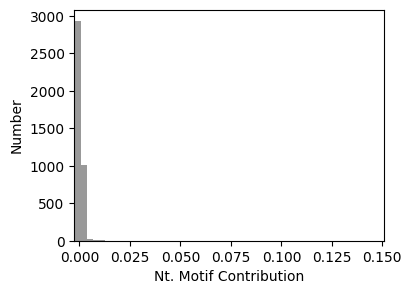

In [54]:
hp_args = {'bins': 50, 'color': 'Gray', 'alpha': 0.8, 
           'ylabel': 'Number', 'figsize': (4, 3)}

HistPlot(motif_scores.reshape(-1), **hp_args, 
         xlabel = 'Nt. Motif Contribution')

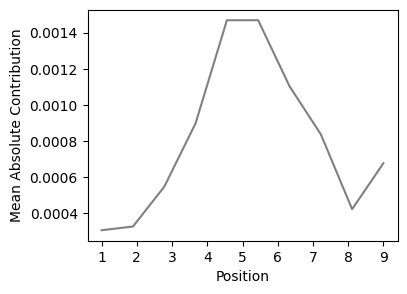

In [55]:
cents_contribs_abs_mean = np.mean(np.abs(motif_scores), axis = 0)

lp_args = {'figsize': (4,3), 'color': 'Gray', 
           'xlabel': 'Position', 
           'ylabel': 'Mean Absolute Contribution'}

LinePlot(cents_contribs_abs_mean, **lp_args, 
         xticklabel = np.arange(9) + 1)
         

### Reg motifs

In [41]:
sw = True
uniq = True

hys_motif_args = {'sub_model': 'A', 'k': best_oyster_config['A_H_size'],
                  
                  
                  'joint': best_oyster_config['A_joint'], 
            'random_seqs': 20000, 'unique': uniq, 
            'scoreweight': sw, 'batchsize': 8192}

# nonshif_scores = []

# for ip, ppm in enumerate(all_matrixes):
#     nonshif_scores.append(Oys_ScoreMotif_vX(pn_ob_all_mod, ppm, **hys_motif_args))
#     if ip % 10 == 0: print(f'finished {ip}')

# nonshif_scores = np.squeeze(np.stack(nonshif_scores))

# PickleDump(nonshif_scores, moved + 'ensemble_' + 'nonshif_scores')

In [44]:
nonshif_scores = PickleLoad(moved + 'ensemble_' + 'nonshif_scores')

mino, maxo = (np.round(f(nonshif_scores),4) for f in [np.min, np.max])
print(mino, maxo)

pdo = pd.DataFrame(data = np.array(all_names_filt), columns = ['Motif'])

poss = np.arange(1, 10)
pdo[poss] = nonshif_scores

shif_scores_maxs2 = np.max(np.abs(nonshif_scores), axis = 1)
sorto = np.argsort(shif_scores_maxs2)[::-1]

pdx = pdo.iloc[sorto] #.iloc[:40]

pdx_sty = pdx.style.format(precision=3).background_gradient(cmap = 'Grays', axis = None, subset = poss,
                                                            vmin = mino, vmax = maxo)
pdx_sty.to_excel("motifs.xlsx")

pdx_sty2 = pdx.iloc[:40].style.format(precision=3).background_gradient(cmap = 'Grays', axis = None, subset = poss,
                                                            vmin = mino, vmax = maxo)
pdx_sty2

-0.1331 0.8599


,Motif,1,2,3,4,5,6,7,8,9
328,TYY1,0.178,0.126,0.410,0.803,0.860,0.802,0.400,0.122,0.181
344,ZFP42,0.101,0.060,0.208,0.399,0.413,0.394,0.200,0.062,0.108
314,TF65,0.033,0.022,0.017,0.000,-0.133,-0.016,0.002,0.031,0.041
197,NFKB1,0.033,0.019,0.016,-0.002,-0.122,-0.018,0.002,0.029,0.041
198,NFKB2,0.033,0.017,0.016,-0.001,-0.118,-0.017,0.002,0.027,0.041
255,RELB,0.032,0.020,0.015,-0.002,-0.114,-0.016,0.001,0.032,0.041
193,NFAC4,0.025,0.017,0.025,-0.003,-0.106,-0.016,0.011,0.032,0.034
339,ZBT48,0.031,0.021,0.014,-0.016,-0.104,-0.028,0.001,0.035,0.042
192,NFAC3,0.021,0.020,0.017,0.001,-0.103,-0.010,0.003,0.034,0.031
191,NFAC2,0.020,0.022,0.018,-0.002,-0.100,-0.012,0.005,0.037,0.030


## From EpiProfiles

In [17]:
histones = ['H3K4me3', 'H3K27ac', 'H3K27me3', 'H3K4me1', 'H3K36me3', 'H3K9me3', 'H3K9ac', 
            'H3K4me2', 'H4K20me1', 'H2AFZ', 'H3K79me2']

### Signal Contributions

In [92]:
# I want to determine the contribution of each signal to each prediction. 

def Oys_SigContrib(model, inp, 
                   sub_model = '', joint = False, 
                   batchsize = 256):
    
    shapo = inp.shape #the 2nd dimension is always the number of sigs. 
    num_sigs = shapo[1]

    if isinstance(model, list) is False: model = [model]
    if sub_model is None: sub_model = ''

    lk = len(inp)

    fullbatches = lk // batchsize
    rem = lk % batchsize

    fins = []

    for fb in np.arange(fullbatches + (rem > 0)):

        fo = fb*batchsize
        batch = inp[fo:fo + batchsize]

        fin = []

        for mo in model: 

            if isinstance(mo, str): mo = LoadTorch(mo)

            with torch.no_grad(): 
                mo.eval()

                Dweight = getattr(mo, 'D' + sub_model)[0].weight
                Dweight = torch.unsqueeze(Dweight, 0)

                x = torch.FloatTensor(batch).to(device)
                if joint: x = getattr(mo, 'Reflect' + sub_model)(x)
            
                x = getattr(mo, 'H' + sub_model)(x)
                x = getattr(mo, 'O' + sub_model)(x)
                x = getattr(mo, 'C' + sub_model)(x)
                
                x = torch.unsqueeze(x, axis = 1)
                x = x * Dweight
                x = torch.squeeze(torch.sum(x, axis = 3))

                xshapo = x.shape
                x = torch.sum(x.reshape(xshapo[0], num_sigs, xshapo[-1] // num_sigs), -1)

                fin.append(x.cpu().detach().numpy())

        fin = np.mean(np.stack(fin), axis = 0)
        fins.append(fin) 
        
    return np.vstack(fins)

In [94]:
sig_contribs = Oys_SigContrib(pn_ob_all_mod, dx2, 
                              sub_model = 'B', joint = False)

In [106]:
xo = np.stack([np.mean(sig_contribs[db.reshape(-1) == b], 0) for b in np.arange(bins)])

pdx = pd.DataFrame(xo.T)
pdx.index = histones

pdx_sty = pdx.style.format(precision=3).background_gradient(cmap = 'Greys', axis = None, vmin = 0.01)
pdx_sty

,0,1,2,3,4,5,6,7,8,9
H3K4me3,-0.002,0.018,0.025,0.029,0.030,0.033,0.035,0.037,0.038,0.035
H3K27ac,0.004,0.006,0.008,0.009,0.010,0.011,0.011,0.013,0.015,0.022
H3K27me3,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001
H3K4me1,0.001,0.003,0.005,0.005,0.006,0.006,0.007,0.007,0.006,0.006
H3K36me3,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003
H3K9me3,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003
H3K9ac,-0.002,0.007,0.009,0.010,0.011,0.012,0.013,0.013,0.014,0.013
H3K4me2,-0.012,0.014,0.020,0.023,0.025,0.028,0.029,0.030,0.031,0.029
H4K20me1,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003
H2AFZ,0.009,0.020,0.022,0.024,0.026,0.027,0.030,0.035,0.040,0.043


In [111]:
hisos = np.swapaxes(dx2, 0, 1).reshape(11, -1)

for ih1, h1 in enumerate(histones): 
    for ih2, h2 in enumerate(histones): 
        if h1 != h2: 
            cor = Correlation(hisos[ih1], hisos[ih2]) ** 2
            if cor > 0.7 or cor < -0.7 : print(f'{h1, h2, cor}')

('H3K4me3', 'H3K9ac', 0.796959636596188)
('H3K4me3', 'H3K4me2', 0.8759356094573604)
('H3K27ac', 'H3K9ac', 0.782399517397262)
('H3K9ac', 'H3K4me3', 0.796959636596188)
('H3K9ac', 'H3K27ac', 0.7823995173972621)
('H3K4me2', 'H3K4me3', 0.8759356094573603)


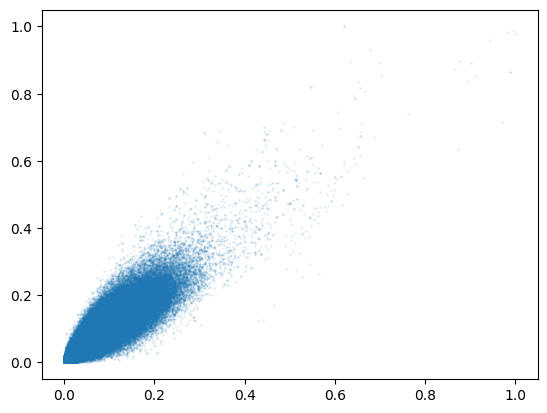

In [114]:
plt.scatter(*[x[::10] for x in [hisos[0], hisos[7]]], alpha = 0.2, s = 0.2)

In [19]:
his_signals = dx2
H_size = best_oyster_config['B_H_size']

# his_signals_win = TridentWindow(his_signals, H_size)
# PickleDump(his_signals_win, moved + 'his_signals_win')

In [20]:
num_clust = 100

osc_args = {'H_size': best_oyster_config['B_H_size'],
            'num_clusters': num_clust, 'sample': 1000000}
          
# his_signals_clustered = Oys_SigCluster(his_signals, **osc_args)

# PickleDump(his_signals_clustered,  moved + 'his_signals_clustered')

In [20]:
# his_signals_win = PickleLoad(moved + 'his_signals_win')
# his_signals_clustered = PickleLoad(moved + 'his_signals_clustered')


# his_signals_clustered_ref = np.stack([RefineClusters(his_signals_win[:, c, :, 0], his_signals_clustered[:, c]) 
#                                       for c in np.arange(len(histones))], axis = 1)

# PickleDump(his_signals_clustered_ref, moved + 'his_signals_clustered_ref')

In [21]:
#SUB SAMPLING FOR STORAGE PURPOSES. 

# his_signals_win = PickleLoad(moved + 'his_signals_win')
# his_signals_clustered_ref = PickleLoad(moved + 'his_signals_clustered_ref')

# his_subsamp = SubSample_Random(his_signals_clustered_ref, proportion = 0.5)
# PickleDump(his_subsamp, moved + 'his_subsamp')

# his_signals_win_subsamp = his_signals_win[his_subsamp]
# PickleDump(his_signals_win_subsamp, moved + 'his_signals_win_subsamp')

# his_signals_clustered_ref_subsamp =  his_signals_clustered_ref[his_subsamp]
# PickleDump(his_signals_clustered_ref_subsamp, moved + 'his_signals_clustered_ref_subsamp')

In [22]:
# his_signals_win_subsamp = PickleLoad(moved + 'his_signals_win_subsamp')

# oss_args = {#'H_size': best_oyster_config['B_H_size'], 
#             'sub_model': 'B', 'joint': best_oyster_config['B_joint'], 
#             'chunk': True, 'batchsize': 63768}

# his_signals_contrib_subsamp = Oys_ScoreSignals(pn_ob_all_mod, his_signals_win_subsamp, **oss_args)

# PickleDump(his_signals_contrib_subsamp, moved + 'ensemble_' + 'his_signals_contrib_subsamp')

In [ ]:
# his_signals_win_subsamp = PickleLoad(moved + 'his_signals_win_subsamp')
# his_signals_clustered_ref_subsamp = PickleLoad(moved + 'his_signals_clustered_ref_subsamp')

# his_signals_contrib_subsamp = PickleLoad(moved + 'ensemble_' + 'his_signals_contrib_subsamp') ###################

# his_signals_centroids_subsamp = Oys_SigCentroids(his_signals_win_subsamp, his_signals_contrib_subsamp, 
#                                          his_signals_clustered_ref_subsamp, weighted = True)

# PickleDump(his_signals_centroids_subsamp,  moved + 'ensemble_' + 'his_signals_centroids_subsamp')

In [24]:
his_signals_centroids_subsamp = PickleLoad(moved + 'ensemble_' + 'his_signals_centroids_subsamp')

cents, cents_contribs = his_signals_centroids_subsamp
cents_contribs = np.squeeze(np.vstack(cents_contribs))

histones = ['H3K4me3', 'H3K27ac', 'H3K27me3', 'H3K4me1', 'H3K36me3', 'H3K9me3', 'H3K9ac', 
            'H3K4me2', 'H4K20me1', 'H2AFZ', 'H3K79me2']

his_names = np.hstack([np.repeat(h, len(cents[ih])) for ih, h in enumerate(histones)])
his_clusts = np.hstack([np.arange(len(cents[ih])) for ih, h in enumerate(histones)])

In [25]:
centos = np.squeeze(np.vstack(cents))

means = np.mean(centos, axis = 1)

centos_norm = centos / means.reshape(-1, 1)

mino, maxo = (f(centos_norm) for f in [np.min, np.max])
print(mino, maxo)

k_names = np.arange(best_oyster_config['B_H_size']) + 1

pdo = pd.DataFrame(data = centos_norm)
pdo.columns = k_names
pdo['Histone'] = his_names
pdo['Cluster'] = his_clusts

pdo = pdo.set_index(['Histone', 'Cluster'])

pdo['Mean'] = means

pdx = pdo#.iloc[sorto].iloc[:50]

pdx_sty = pdx.style.format(precision=3).background_gradient(cmap = 'Greys', axis = None, 
                                                            subset = k_names, 
                                                            vmin = mino, vmax = maxo)
pdx_sty = pdx_sty.background_gradient(cmap = 'Greys', axis = None, 
                                                            subset = 'Mean')

pdx_sty

0.23267421 2.0392957


In [33]:
cents_contribs_pos = cents_contribs / best_oyster_config['B_C_pos']

mino, maxo = (f(cents_contribs_pos) for f in [np.min, np.max])
print(mino, maxo)

his_clust_contribs_maxs = np.max(cents_contribs_pos, axis = -1).reshape(-1)

sorto = np.argsort(his_clust_contribs_maxs)[::-1]


pdo = pd.DataFrame(data = cents_contribs_pos,
                   columns = np.arange(len(cents_contribs_pos.T)))
pdo['Histone'] = his_names
pdo['Cluster'] = his_clusts

pdo = pdo.set_index(['Histone', 'Cluster'])

pdx = pdo.iloc[sorto]#.iloc[:50]

pdx_sty = pdx.style.format(precision=3).background_gradient(cmap = 'Greys', axis = None, 
                                                            vmin = mino, vmax = maxo)
pdx_sty

-0.007671 0.014665999


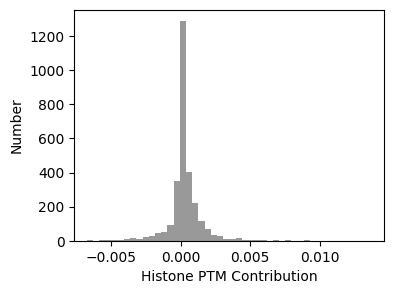

In [34]:
hp_args = {'bins': 50, 'color': 'Gray', 'alpha': 0.8, 
           'ylabel': 'Number', 'figsize': (4, 3)}

HistPlot(cents_contribs_pos.reshape(-1), **hp_args, 
         xlabel = 'Histone PTM Contribution')

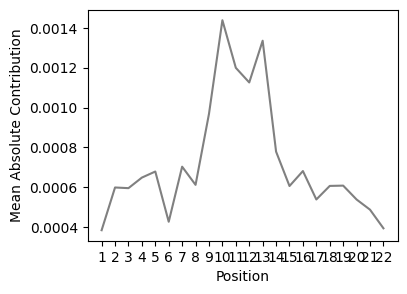

In [36]:
cents_contribs_pos_abs_mean = np.mean(np.abs(cents_contribs_pos), axis = 0)

lp_args = {'figsize': (4,3), 'color': 'Gray', 
           'xlabel': 'Position', 
           'ylabel': 'Mean Absolute Contribution'}

LinePlot(cents_contribs_pos_abs_mean, **lp_args, 
         xticklabel = np.arange(len(cents_contribs_pos.T)) + 1)

array([[<Axes: title={'center': 'H3K27ac-5'}, xlabel='Position (nts)', ylabel='Intensity'>,
        <Axes: title={'center': 'H2AFZ-4'}, xlabel='Position (nts)', ylabel='Intensity'>,
        <Axes: title={'center': 'H2AFZ-11'}, xlabel='Position (nts)', ylabel='Intensity'>,
        <Axes: title={'center': 'H2AFZ-9'}, xlabel='Position (nts)', ylabel='Intensity'>],
       [<Axes: title={'center': 'H3K27ac-1'}, xlabel='Position (nts)', ylabel='Intensity'>,
        <Axes: title={'center': 'H2AFZ-1'}, xlabel='Position (nts)', ylabel='Intensity'>,
        <Axes: title={'center': 'H2AFZ-12'}, xlabel='Position (nts)', ylabel='Intensity'>,
        <Axes: title={'center': 'H2AFZ-10'}, xlabel='Position (nts)', ylabel='Intensity'>],
       [<Axes: title={'center': 'H2AFZ-5'}, xlabel='Position (nts)', ylabel='Intensity'>,
        <Axes: title={'center': 'H2AFZ-8'}, xlabel='Position (nts)', ylabel='Intensity'>,
        <Axes: title={'center': 'H3K4me3-7'}, xlabel='Position (nts)', ylabel='Intensity'>,

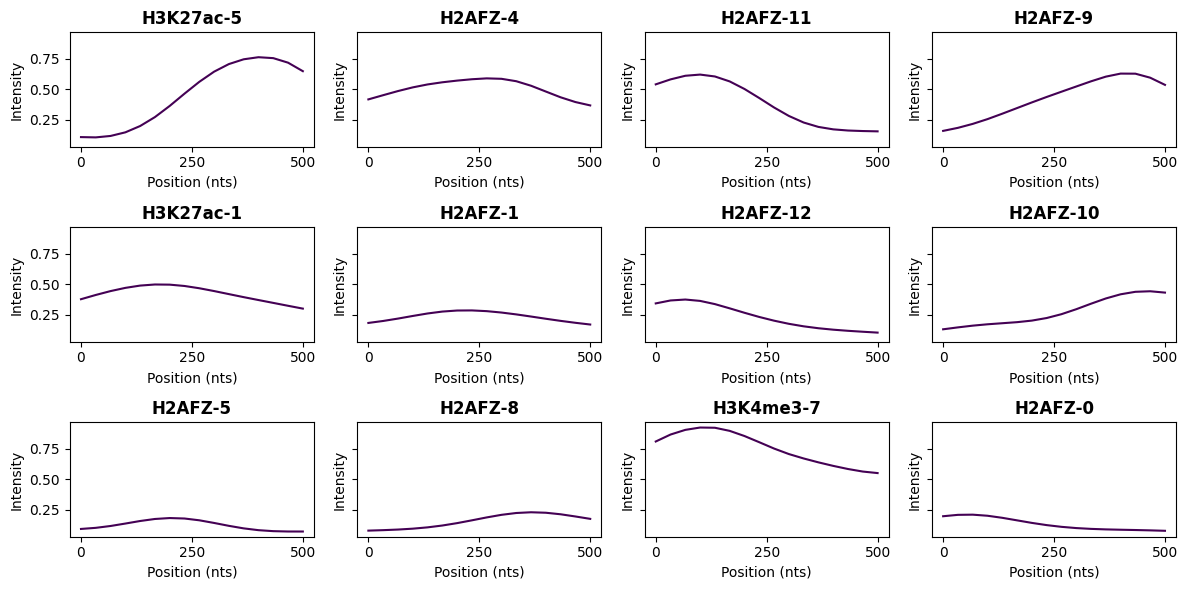

In [37]:
topz = 12
top_x_cents = np.squeeze(np.vstack(cents)[sorto][:topz])
top_x_names = [x + '-' + str(y) for x,y in zip(his_names[sorto][:topz], his_clusts[sorto][:topz])]

mp_args = {'multi': True, 'paired': False, 'transpose': False, 
           'columntitle': None,
           'rowtitle': None, 'rowtitle_rotation': True,
           'figsize': (12, 6), 'fontsize': 10,
           'sharey': True, 'sharex': False, 


           'indiv_args': {'suptitle': top_x_names}}

line_args = {'xticklabel': [0, 10*50 // 2, 10*50], 'xlabel': 'Position (nts)', 'ylabel': 'Intensity'}


MultiPlot(top_x_cents, **mp_args, customgrid=(3,4),
                 plt_mode = [LinePlot, line_args])

In [45]:
# I want to determine the contribution of each signal to each prediction. 

def Oys_SigContrib(model, inp, 
                   sub_model = '', joint = False, chunk = False,
                     batchsize = 256): 
    
    num_sigs = inp.shape[1] #the 2nd dimension is always the number of sigs. 

    if isinstance(model, str): model = LoadTorch(model)

    if sub_model is None: sub_model = ''

    with torch.no_grad(): 
        model.eval()

        Dweight = getattr(model, 'D' + sub_model)[0].weight
        Dweight = torch.unsqueeze(Dweight, 0)

        x = inp
        if joint: x = getattr(model, 'Reflect' + sub_model)(x)

        print(x.shape)
    
        x = getattr(model, 'H' + sub_model)(x)
    
        x = getattr(model, 'O' + sub_model)(x)
            
        x = torch.unsqueeze(x, axis = 1)
        
        print(x.shape, Dweight.shape) ######################

        x = x * Dweight

        if chunk: 
            xshapo = x.shape
            x = x.reshape(xshapo[0], xshapo[1], shapo[1], xshapo[2] // shapo[1], *xshapo[-2:])
            x = torch.sum(x, axis = 3)
        else: 
            x = torch.sum(x, axis = -3)

        if joint: x = torch.unsqueeze(torch.mean(x, axis = -1), dim= -1)

    return x.cpu().detach().numpy()




In [46]:
tt2 = Oys_SigContrib(pn_ob_all_mod[0], dx2[:10], 
                     sub_model = 'B', joint = False, chunk = False,
                     batchsize = 256)

(10, 11, 80, 1)


TypeError: conv2d() received an invalid combination of arguments - got (numpy.ndarray, Parameter, Parameter, tuple, str, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !Parameter!, !Parameter!, !tuple of (int, int)!, !str!, !tuple of (int, int)!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !Parameter!, !Parameter!, !tuple of (int, int)!, str, !tuple of (int, int)!, int)


In [40]:
ttt = Oys_ScoreSignals(pn_ob_all_mod, dx2[:10], sub_model = 'B')

RuntimeError: The size of tensor a (65) must match the size of tensor b (22) at non-singleton dimension 3

In [ ]:
mp_args = {'multi': True, 'paired': False, 'transpose': False, 
           'columntitle': None,
           'rowtitle': None, 'rowtitle_rotation': True,
           'figsize': (9, 6), 'fontsize': 10,
           'sharey': True, 'sharex': False, 


           'indiv_args': {'suptitle': pdx.iloc[:6]['Cluster'].to_list()}}

line_args = {'xticklabel': [0, 9*50 // 2, 9*50], 'xlabel': 'Position (nts)', 'ylabel': 'Averaged Intensity'}



MultiPlot(his_clust_acts[pdx.index[:6]], **mp_args, customgrid=(3,3),
                 plt_mode = [LinePlot, line_args])

In [ ]:
# his_signals_contrib = PickleLoad(moved + 'his_signals_contrib')
# his_signals_clustered = PickleLoad(moved + 'his_signals_clustered')

histones = ['H3K4me3', 'H3K27ac', 'H3K27me3', 'H3K4me1', 'H3K36me3', 'H3K9me3', 'H3K9ac', 
            'H3K4me2', 'H4K20me1', 'H2AFZ', 'H3K79me2']

import seaborn as sns

his_clust_names = []
his_clust_acts = []
his_clust_contribs = []

for ih, h in enumerate(histones):
    contribs = his_signals_contrib[:, :, ih, :, 0]
    cluster_idxs = [np.where(his_signals_clustered[:, ih] == n)[0] for n in np.arange(num_clust)]
    
    meanos_act = np.stack([np.mean(his_signals_win[:, ih, :, 0][cidx], axis = 0) for cidx in cluster_idxs]) 
    meanos_contribs = np.stack([np.mean(contribs[cidx], axis = 0) for cidx in cluster_idxs]) 

    obx = sns.clustermap(np.squeeze(meanos_act), col_cluster = False)
    neworder = obx.dendrogram_row.reordered_ind

    meanos_act_no = meanos_act[neworder]
    his_clust_acts.append(meanos_act_no)

    meanos_contribs_no = meanos_contribs[neworder]
    his_clust_contribs.append(meanos_contribs_no)

    cluster_names = [h + '_' + str(n) for n in np.arange(num_clust)]
    his_clust_names.extend(cluster_names)


his_clust_acts = np.vstack(his_clust_acts)
his_clust_contribs = np.vstack(his_clust_contribs)

[PickleDump(x, moved + y) for x,y in zip([his_clust_names, his_clust_acts, his_clust_contribs], 
                                                ['his_clust_names', 'his_clust_acts', 'his_clust_contribs'])]

In [38]:
# his_clust_names, his_clust_acts, his_clust_contribs = [PickleLoad(moved + y) 
#                                                        for y in ['his_clust_names', 'his_clust_acts', 'his_clust_contribs']]

mino, maxo = (f(his_clust_contribs) for f in [np.min, np.max])
print(mino, maxo)

pdo = pd.DataFrame(data = np.array(his_clust_names), columns = ['Cluster'])

poss = np.arange(best_oyster_config['B_C_pos'])
pdo[poss] = his_clust_contribs[:, 0]

his_clust_contribs_maxs = np.max(his_clust_contribs, axis = -1).reshape(-1)
sorto = np.argsort(his_clust_contribs_maxs)[::-1]

pdx = pdo.iloc[sorto].iloc[:45]

pdx_sty = pdx.style.format(precision=3).background_gradient(cmap = 'Purples', axis = None, subset = poss, 
                                                            vmin = mino, vmax = maxo)
pdx_sty

-0.18894604 0.2317586


,Cluster,0,1,2,3,4,5
100,H3K27ac_0,0.104,-0.108,0.232,0.010,0.006,-0.046
114,H3K27ac_14,0.119,-0.083,0.175,0.001,0.041,-0.034
997,H2AFZ_97,-0.189,0.006,0.171,0.105,0.118,-0.070
115,H3K27ac_15,0.101,-0.062,0.147,-0.003,0.043,-0.036
799,H3K4me2_99,0.001,0.048,0.071,-0.024,0.076,0.138
798,H3K4me2_98,0.019,-0.024,-0.024,-0.062,0.050,0.130
200,H3K27me3_0,0.126,-0.003,-0.150,-0.018,-0.002,-0.148
191,H3K27ac_91,0.044,-0.056,0.116,0.010,-0.008,-0.021
116,H3K27ac_16,0.042,-0.045,0.106,0.001,0.005,-0.026
692,H3K9ac_92,-0.014,-0.050,0.103,-0.093,0.046,0.022


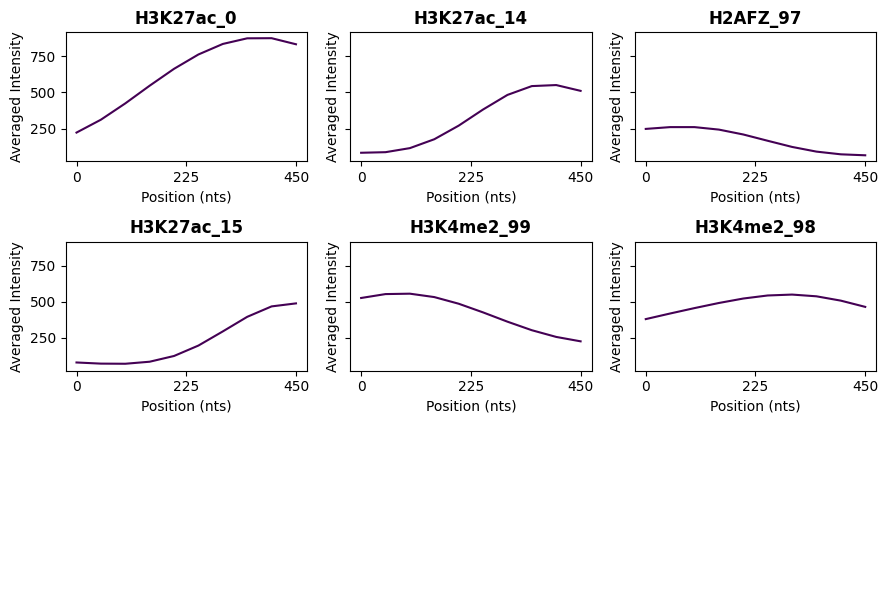

In [40]:


mp_args = {'multi': True, 'paired': False, 'transpose': False, 
           'columntitle': None,
           'rowtitle': None, 'rowtitle_rotation': True,
           'figsize': (9, 6), 'fontsize': 10,
           'sharey': True, 'sharex': False, 


           'indiv_args': {'suptitle': pdx.iloc[:6]['Cluster'].to_list()}}

line_args = {'xticklabel': [0, 9*50 // 2, 9*50], 'xlabel': 'Position (nts)', 'ylabel': 'Averaged Intensity'}



MultiPlot(his_clust_acts[pdx.index[:6]], **mp_args, customgrid=(3,3),
                 plt_mode = [LinePlot, line_args])

## k-motifs

In [20]:
def CM2PFM(CM): 
    sums = np.sum(CM, axis = 1).reshape(-1, 1)
    return CM / sums

def kmersFromPPM(ppm, num = 10000, unique = False):

    lets = [np.random.choice(['A', 'C', 'G', 'T'], 
                                     size = num, replace = True, 
                                     p = px) for px in ppm]
    
    kmers = [''.join(row) for row in np.stack(lets, axis = 1)]

    if unique: kmers = list(np.unique(kmers))
    
    return kmers

def OysKmerContrib(model, inp, dir_sym = False, mod = None, chunk = False): 

    if mod is None: mod = ''

    # DOES NOT DO REVCOMP RIGHT NOW. 

    shapo = inp.shape


    with torch.no_grad(): 
        model.eval()

        Dweight = getattr(model, 'D' + mod).weight

        if len(getattr(model, 'C' + mod)) > 1: #MEANS ITS POSITIONAL. 
            Cweight = getattr(model, 'C' + mod)[-2].weight
            Cweight_mod = torch.unsqueeze(torch.squeeze(Cweight, 1), 0)
            #print(f'Cweight: {Cweight.shape}, Cweight_mod: {Cweight_mod.shape}, Dweight: {Dweight.shape}')

        else: Cweight_mod = 1
    
        x = getattr(model, 'H' + mod)(inp)
        x = getattr(model, 'O' + mod)(x)
        x = getattr(model, 'Sym' + mod)(x)
            
        x = x * Cweight_mod
        x = x * Dweight

        

        if chunk: 
            xshapo = x.shape
            x = x.reshape(shapo[0], shapo[1], xshapo[1] // shapo[1], *xshapo[2:])
            
            x = torch.sum(x, axis = 2)
            
       
        else: 
            x = torch.unsqueeze(torch.sum(x, axis = -3), axis = 1)
        
        if dir_sym: x = (x + torch.flip(x, dims = [2])) / 2

    return x.cpu().detach().numpy()


def Oyster_ScorePPM_v2(model, ppm, 
                       mod = '', dir_sym = False,
                       random_seqs = 10000, unique = True, 
                       newmeth = True, p = 2,
                       scoreweight = True, 
                       batchsize = 256):

    #generates kmers from the ppm and scores them to the final output
    # CURRENTLY ONLY SUPPORTS ONE HEADED OYSTER MODEL
    #ppm must be the same size as what the Hydra head uses 
    #can do two types of scoring: distance or new method


    kmers = kmersFromPPM(ppm, num = random_seqs, unique = unique)
    kmers_OHE = Seqs2OHE(kmers)

    lk = len(kmers)
    
    kmers_scored = PPMScorer(kmers_OHE, ppm, newmeth=newmeth, p = p).reshape(-1, 1, 1, 1) if scoreweight else 1

    fullbatches = lk // batchsize
    rem = lk % batchsize

    fins = []

    for fb in np.arange(fullbatches + (rem > 0)):

        fo = fb*batchsize

        batch = kmers_OHE[fo:fo + batchsize]

        O = torch.FloatTensor(np.expand_dims(batch, axis = 1)).to(device)

        fin = OysKmerContrib(model, O, dir_sym = dir_sym, mod = mod)
        fins.append(fin)
    
    fins = np.vstack(fins)

    out = np.sum((fins * kmers_scored), axis = 0) / np.sum(kmers_scored) if scoreweight else np.mean(fins, axis = 0)

    return out

In [18]:
human_core_motifs = '../../Essentials/motif_databases/HUMAN/HOCOMOCOv11_core_HUMAN_mono_meme_format.meme'

name_idx = 1
all_names, all_matrixes = MEME2Motifs(human_core_motifs, name_idx = name_idx)

all_names_filt = [a.split('_HUMAN')[0] for a in all_names]
all_names_filt[:10]

['AHR',
 'AIRE',
 'ALX1',
 'ANDR',
 'AP2A',
 'AP2B',
 'AP2C',
 'ARI5B',
 'ARNT',
 'ASCL1']

In [19]:
shif_names, shif_matrixes = [], []

leno = best_oyster_config['A_H_size']

for n,m in zip(all_names_filt, all_matrixes):
    shifm, shifn = ShiftedMotifs(m, length = leno, name = n)
    shif_names.extend(shifn)
    shif_matrixes.extend(shifm)

print(len(shif_matrixes), len(shif_names))

3184 3184


In [20]:
best_oyster_config['A_dir_sym']

True

In [21]:
# sw = True
# uniq = True

# hys_args = {'mod': 'A', 'dir_sym': best_oyster_config['A_dir_sym'], 
#             'random_seqs': 20000, 'unique': uniq, 
#             'newmeth': True, 'scoreweight': sw, 'batchsize': 8192}

# shif_scores = []

# for ip, ppm in enumerate(shif_matrixes):
#     shif_scores.append(Oyster_ScorePPM_v2(ob_mod, ppm, **hys_args))
#     if ip % 10 == 0: print(f'finished {ip}')

# shif_scores = np.squeeze(np.stack(shif_scores))

# PickleDump(shif_scores, pn_RO_bests + 'shif_scores')

In [22]:
shif_scores = PickleLoad(pn_RO_bests + 'shif_scores')

In [65]:
mino, maxo = (f(shif_scores) for f in [np.min, np.max])
print(mino, maxo)

pdo = pd.DataFrame(data = np.array(shif_names), columns = ['k-Motif'])

poss = [1,2,3]
pdo[poss] = shif_scores

shif_scores_maxs = np.max(shif_scores, axis = 1)
sorto = np.argsort(shif_scores_maxs)[::-1]

pdx = pdo.iloc[sorto].iloc[:45]

pdx_sty = pdx.style.format(precision=3).background_gradient(cmap = 'Purples', axis = None, subset = poss,
                                                            vmin = mino, vmax = maxo)
pdx_sty

-168.1648788408443 3539.1892404289747


,k-Motif,1,2,3
2858,TYY1_3,881.472,3539.189,881.472
2862,TYY1_7,783.876,3456.104,783.876
2859,TYY1_4,728.520,3181.559,728.520
2857,TYY1_2,839.494,3158.326,839.494
2863,TYY1_8,695.831,2958.955,695.831
2864,TYY1_9,594.224,2245.827,594.224
2856,TYY1_1,609.470,2148.996,609.470
2839,THAP1_1,563.362,1835.261,563.362
2838,THAP1_0,557.941,1831.523,557.941
2860,TYY1_5,258.137,1486.825,258.137


In [72]:
shif_scores_maxs.shape

(3184,)

In [49]:
pdo = pd.DataFrame(data = np.array(shif_names), columns = ['k-Motif'])

poss = [1,2,3]
pdo[poss] = shif_scores

shif_scores_maxs = np.min(shif_scores, axis = 1)
sorto = np.argsort(shif_scores_maxs)[::1]

pdx = pdo.iloc[sorto].iloc[:45]

pdx_sty = pdx.style.format(precision=3).background_gradient(cmap = 'Purples', axis = None, subset = poss, 
                                                            vmin = mino, vmax = maxo)
pdx_sty

,k-Motif,1,2,3
2536,SP1_0,97.708,-168.165,97.708
2539,SP2_1,93.738,-160.938,93.738
2538,SP2_0,92.273,-155.007,92.273
2541,SP3_1,91.686,-153.642,91.686
2540,SP3_0,89.045,-151.513,89.045
1382,KLF15_2,80.008,-135.393,80.008
2537,SP1_1,79.985,-134.202,79.985
2886,WT1_0,73.327,-123.314,73.327
1393,KLF3_2,73.044,-121.474,73.044
2887,WT1_1,71.971,-119.826,71.971


## From EpiProfiles

In [15]:
# You want for every kmer of real sequence data, you want the contributions x position. 
# so mayebe you get a shape the same as the windowed... 



In [41]:
from sklearn.cluster import KMeans

def TridentWindow(inp, size): 
    ST = np.lib.stride_tricks.sliding_window_view
    winshape = (inp.shape[1], size, inp.shape[-1])
    sig_win = ST(inp, (1, *winshape))
    sig_win_rs = sig_win.reshape(-1, *winshape)
    return sig_win_rs


def Oyster_Score_Signals(model, inp, H_size, 
                         chunk = True, 
                         mod = '', dir_sym = False,
                         batchsize = 256):


    #inp is a trident pack with (num, signal, length, wid) 

    sig_win_rs = TridentWindow(inp, H_size)

    lk = len(sig_win_rs)

    fullbatches = lk // batchsize
    rem = lk % batchsize

    fins = []

    for fb in np.arange(fullbatches + (rem > 0)):

        fo = fb*batchsize

        batch = sig_win_rs[fo:fo + batchsize]
        O = torch.FloatTensor(batch).to(device)

        fin = OysKmerContrib(model, O, dir_sym = dir_sym, mod = mod, chunk = chunk)
        fins.append(fin)
    
    fins = np.vstack(fins)

    return fins

def Oyster_SigCluster(inp, H_size,
                      num_clusters = 10, sample = None,
                      chunk = True, 
                      cluster_mode = [KMeans, {}]):
        
    sig_win_rs = TridentWindow(inp, H_size)
    
    lk = len(sig_win_rs)

    if isinstance(sample, int): 
        rando = np.random.choice(np.arange(lk), sample, replace=False)

    if chunk: 

        clustod = []
        for i in np.arange(H_size):

            sig = sig_win_rs[:, i].reshape(lk, -1)
            sig_samp = sig[rando] if isinstance(sample, int) else sig

            print(sig_samp.shape)



            clust = cluster_mode[0](n_clusters = num_clusters, **cluster_mode[1])
            clust.fit(sig_samp)

            clustod.append(clust.predict(sig))

            print(f'finished: {i}')
        
        clustod = np.stack(clustod, axis = 1)
    
    return clustod


In [44]:
pack_histone_scores = PickleLoad(mainfolder + 'pack_histone_scores')

his_scores_Tri = np.expand_dims(np.swapaxes(pack_histone_scores, -1, -2), axis = -1)


H_size = best_oyster_config2['B_H_size']
his_scores_win = TridentWindow(his_scores_Tri, H_size)

his_scores_win.shape

(3800000, 11, 9, 1)

In [45]:
pack_histone_scores = PickleLoad(mainfolder + 'pack_histone_scores')

histone_scores_Tri = np.expand_dims(np.swapaxes(pack_histone_scores, -1, -2), axis = -1)

oss_args = {'H_size': best_oyster_config2['B_H_size'], 'mod': 'B', 
            'chunk': True, 'batchsize': 2024, 
            'dir_sym': False}                 ###best_oyster_config['B_dir_sym']} SHOULD BE FALSE FOR HIS CLUSTERS. 


his_contribs = Oyster_Score_Signals(ob_mod, histone_scores_Tri, **oss_args)

PickleDump(his_contribs,  pn_RO_bests + 'his_contribs')

In [46]:
num_clust = 100

# osc_args = {'H_size': best_oyster_config['B_H_size'],
#             'num_clusters': num_clust, 'sample': 1000000}
          

# his_clustered = Oyster_SigCluster(his_scores_Tri, **osc_args)

# PickleDump(his_clustered,  pn_RO_bests + 'his_clustered')

In [25]:
his_contribs = PickleLoad(pn_RO_bests + 'his_contribs')
his_clustered = PickleLoad(pn_RO_bests + 'his_clustered')

print(his_contribs.shape, his_clustered.shape)

(3600000, 11, 6, 1) (3600000, 11)


In [37]:
np.argmax(np.max(his_contribs[:, 0, :, 0], axis = 1))

2052346

In [38]:
his_contribs[2052346, 0, :, 0]

array([  40.54444, -120.79396,  183.13603,  164.43224, -105.83667,
         -7.28238], dtype=float32)

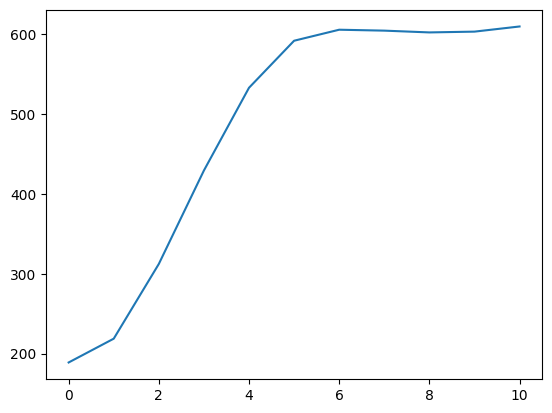

In [28]:
plt.plot(his_scores_win[2052346, 0, :, 0])

In [ ]:


histones = ['H3K4me3', 'H3K27ac', 'H3K27me3', 'H3K4me1', 'H3K36me3', 'H3K9me3', 'H3K9ac', 
            'H3K4me2', 'H4K20me1', 'H2AFZ', 'H3K79me2']

import seaborn as sns

his_clust_names = []
his_clust_acts = []
his_clust_contribs = []

for ih, h in enumerate(histones):
    contribs = his_contribs[:, ih, :, 0]
    cluster_idxs = [np.where(his_clustered[:, ih] == n)[0] for n in np.arange(num_clust)]
    
    meanos_act = np.stack([np.mean(his_scores_win[:, ih, :, 0][cidx], axis = 0) for cidx in cluster_idxs]) 
    meanos_contribs = np.stack([np.mean(contribs[cidx], axis = 0) for cidx in cluster_idxs]) 

    obx = sns.clustermap(np.squeeze(meanos_act), col_cluster = False)
    neworder = obx.dendrogram_row.reordered_ind

    meanos_act_no = meanos_act[neworder]
    his_clust_acts.append(meanos_act_no)

    meanos_contribs_no = meanos_contribs[neworder]
    his_clust_contribs.append(meanos_contribs_no)

    cluster_names = [h + '_' + str(n) for n in np.arange(num_clust)]
    his_clust_names.extend(cluster_names)


his_clust_acts = np.vstack(his_clust_acts)
his_clust_contribs = np.vstack(his_clust_contribs)

[PickleDump(x, pn_RO_bests + y) for x,y in zip([his_clust_names, his_clust_acts, his_clust_contribs], 
                                                ['his_clust_names', 'his_clust_acts', 'his_clust_contribs'])]

In [41]:
his_clust_names, his_clust_acts, his_clust_contribs = [PickleLoad(pn_RO_bests + y) 
                                                       for y in ['his_clust_names', 'his_clust_acts', 'his_clust_contribs']]

In [31]:
his_clust_contribs_maxs = np.max(his_clust_contribs, axis = 1)

In [32]:
mino, maxo = (f(his_clust_contribs) for f in [np.min, np.max])
print(mino, maxo)

pdo = pd.DataFrame(data = np.array(his_clust_names), columns = ['Histone Cluster'])

poss = np.arange(6)
pdo[poss] = his_clust_contribs

his_clust_contribs_maxs = np.max(his_clust_contribs, axis = 1)
sorto = np.argsort(his_clust_contribs_maxs)[::-1]

pdx = pdo.iloc[sorto].iloc[:45]

pdx_sty = pdx.style.format(precision=3).background_gradient(cmap = 'Purples', axis = None, subset = poss, 
                                                            vmin = mino, vmax = maxo)
pdx_sty

-45.863495 62.478203


,Histone Cluster,0,1,2,3,4,5
699,H3K9ac_99,17.622,-16.346,54.505,62.478,-42.061,29.843
0,H3K4me3_0,13.323,-45.863,57.618,52.736,-40.598,-2.546
4,H3K4me3_4,10.924,-33.428,44.388,40.549,-31.309,-0.179
676,H3K9ac_76,13.320,-13.667,38.473,43.719,-30.478,21.276
196,H3K27ac_96,-5.932,-8.801,26.593,40.843,-5.020,2.791
3,H3K4me3_3,9.374,-30.233,39.228,35.835,-27.408,-1.036
697,H3K9ac_97,8.147,38.660,-4.001,-0.305,29.265,17.393
687,H3K9ac_87,11.513,-12.236,34.058,38.481,-27.121,18.958
601,H3K9ac_1,17.777,-19.245,9.464,15.226,-26.307,32.398
5,H3K4me3_5,7.912,-24.301,32.231,29.592,-22.223,-0.277


In [71]:
pdx.index

Index([699,   0,   4, 676,   3, 687, 697, 196,   5,   2, 689,  93,  99, 601,
         1, 600,  59, 692, 693, 640, 603,  92, 675, 179, 605, 698, 602,  58,
        61,  89, 696, 606,  72, 680,  98, 199,  96, 694, 195,  95,  60, 894,
       192, 188, 191],
      dtype='int64')

In [74]:
pdx.index[:5]

Index([699, 0, 4, 676, 3], dtype='int64')

In [78]:
pdx.iloc[:5]['Histone Cluster'].to_list()

['H3K9ac_99', 'H3K4me3_0', 'H3K4me3_4', 'H3K9ac_76', 'H3K4me3_3']

In [76]:
his_clust_acts[pdx.index[:5]].shape

(5, 11)

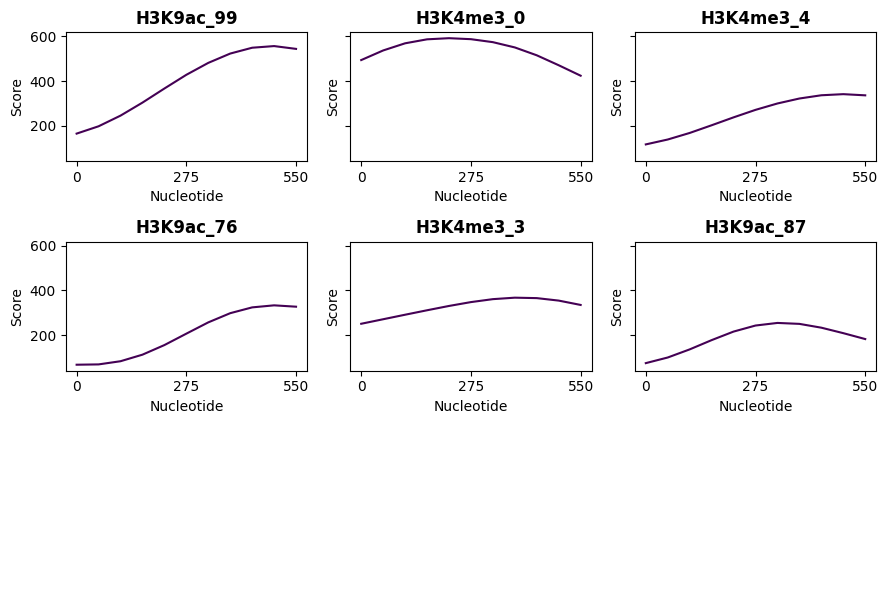

In [96]:


mp_args = {'multi': True, 'paired': False, 'transpose': False, 
           'columntitle': None,
           'rowtitle': None, 'rowtitle_rotation': True,
           'figsize': (9, 6), 'fontsize': 10,
           'sharey': True, 'sharex': False, 


           'indiv_args': {'suptitle': pdx.iloc[:6]['Histone Cluster'].to_list()}}

line_args = {'xticklabel': [0, 11*50 // 2, 11*50], 'xlabel': 'Nucleotide', 'ylabel': 'Score'}



MultiPlot(his_clust_acts[pdx.index[:6]], **mp_args, customgrid=(3,3),
                 plt_mode = [LinePlot, line_args])

In [55]:
his_clust_contribs_mins

array([-43.2307  , -18.858757, -19.5364  , ...,  -7.122113,  -8.151381,
        -7.945551], dtype=float32)

In [63]:
pdo = pd.DataFrame(data = np.array(his_clust_names), columns = ['Histone Cluster'])

poss = np.arange(6)
pdo[poss] = his_clust_contribs

sorto = np.argsort(his_clust_contribs_maxs)[::1]

pdx = pdo.iloc[sorto].iloc[:45]

pdx_sty = pdx.style.format(precision=3).background_gradient(cmap = 'Purples', axis = None, subset = poss,
                                                            vmin = mino, vmax = maxo)
pdx_sty

,Histone Cluster,0,1,2,3,4,5
111,H3K27ac_11,-0.544,-2.991,-4.501,-4.501,-2.991,-0.544
110,H3K27ac_10,-0.485,-2.686,-4.046,-4.046,-2.686,-0.485
109,H3K27ac_9,-0.446,-2.465,-3.716,-3.716,-2.465,-0.446
108,H3K27ac_8,-0.333,-1.814,-2.754,-2.754,-1.814,-0.333
107,H3K27ac_7,-0.274,-1.482,-2.257,-2.257,-1.482,-0.274
114,H3K27ac_14,-0.216,-1.140,-1.757,-1.757,-1.140,-0.216
112,H3K27ac_12,-0.156,-0.805,-1.256,-1.256,-0.805,-0.156
115,H3K27ac_15,-0.144,-0.727,-1.136,-1.136,-0.727,-0.144
113,H3K27ac_13,-0.113,-0.572,-0.837,-0.837,-0.572,-0.113
117,H3K27ac_17,-0.098,-0.566,-0.867,-0.867,-0.566,-0.098


In [68]:
np.stack(his_clust_acts[x] for x in [69]

array([164.15433, 196.9642 , 244.7582 , 303.1064 , 366.3206 , 427.80142,
       481.25073, 523.0353 , 549.1854 , 556.5981 , 544.0025 ],
      dtype=float32)

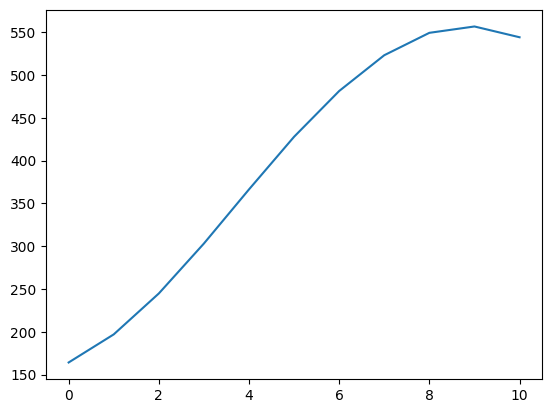

In [67]:
plt.plot(his_clust_acts[699])

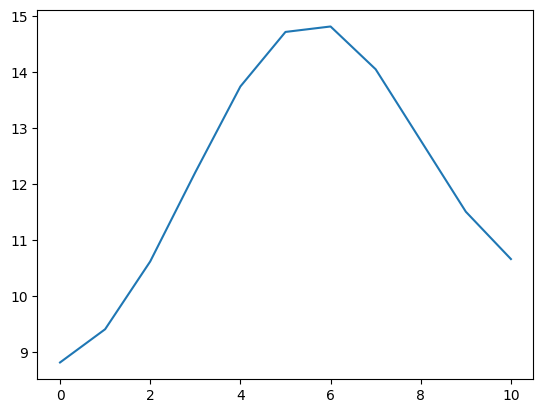

In [83]:
plt.plot(his_clust_acts[115])

In [41]:
meanos_contribs.shape

(100, 6)

In [31]:
cluster_idxs[0][0].shape

(11579,)

In [26]:
obx.dendrogram_row.reordered_ind

[73,
 6,
 74,
 33,
 88,
 55,
 94,
 29,
 86,
 41,
 99,
 53,
 10,
 67,
 44,
 51,
 96,
 75,
 90,
 0,
 20,
 81,
 16,
 97,
 91,
 14,
 56,
 83,
 52,
 11,
 32,
 59,
 37,
 7,
 62,
 21,
 42,
 9,
 19,
 38,
 80,
 68,
 76,
 69,
 18,
 15,
 65,
 34,
 63,
 60,
 84,
 2,
 5,
 40,
 95,
 17,
 78,
 82,
 22,
 58,
 8,
 46,
 79,
 50,
 71,
 98,
 49,
 36,
 93,
 27,
 85,
 3,
 77,
 30,
 57,
 24,
 92,
 39,
 66,
 26,
 48,
 45,
 43,
 4,
 35,
 61,
 1,
 54,
 25,
 70,
 89,
 12,
 28,
 31,
 23,
 87,
 13,
 64,
 47,
 72]

In [73]:
histone_scores_Tri = np.expand_dims(np.swapaxes(pack_histone_scores, -1, -2), axis = -1)

In [74]:
histone_scores_Tri.shape

(100000, 11, 46, 1)

In [78]:
ST = np.lib.stride_tricks.sliding_window_view

winshape = (11, 15, 1)
his_win = ST(histone_scores_Tri, (1, *winshape))

his_win_rs = his_win.reshape(-1, *winshape)
his_win_rs.shape

(3200000, 11, 15, 1)

In [80]:
his_win_rs[0][0]

array([[12.578204 ],
       [10.095645 ],
       [ 6.836139 ],
       [ 7.7332745],
       [10.624178 ],
       [16.92419  ],
       [27.00757  ],
       [33.141445 ],
       [39.88678  ],
       [41.45843  ],
       [37.90813  ],
       [35.510284 ],
       [30.523544 ],
       [28.312237 ],
       [24.127556 ]], dtype=float32)

In [81]:
his_win_rs[1][0]

array([[10.095645 ],
       [ 6.836139 ],
       [ 7.7332745],
       [10.624178 ],
       [16.92419  ],
       [27.00757  ],
       [33.141445 ],
       [39.88678  ],
       [41.45843  ],
       [37.90813  ],
       [35.510284 ],
       [30.523544 ],
       [28.312237 ],
       [24.127556 ],
       [20.814499 ]], dtype=float32)

# Best Model 2

In [11]:
from poseydon.hydra import *


pn_oys = NewFolder('yy1_oyster')
pn_RO = NewFolder(pn_oys + 'ROG')
pn_RO_bests = NewFolder(pn_RO + 'ROG_bests')

best_oyster_config2 = PickleLoad(pn_RO_bests + 'best_oyster_config2')

best_oyster_config2

{'A_dim_i': (1, 500, 4),
 'B_dim_i': (11, 40, 1),
 'dim_f': (1, 1, 1),
 'A_H_grouped': False,
 'B_H_grouped': True,
 'A_doublestrand': True,
 'A_orient_sym': False,
 'A_dir_sym': True,
 'A_H_size': 19,
 'A_H_filt_m': 241,
 'A_H_ns_filters': 1.019974792192755,
 'A_H_base_kernel': 6,
 'A_H_1x1': False,
 'A_C_pos': 9,
 'B_doublestrand': True,
 'B_orient_sym': False,
 'B_dir_sym': False,
 'B_H_size': 9,
 'B_H_filt_m': 20,
 'B_H_ns_filters': 1.1901086006636872,
 'B_H_base_kernel': 3,
 'B_H_1x1': True,
 'B_C_pos': 6,
 'C_pool_func': torch.nn.modules.pooling.AvgPool2d,
 'activations': LeakyReLU(negative_slope=0.01),
 'batchnorm': 'before',
 'batchsize': 256,
 'learningrate': 0.0016388107885277267}

In [12]:
xp_unit = 5
bestloc = pn_RO_bests

ob_allmets_comb = PickleLoad(bestloc + 'RO_bests' + '_allmets_comb')

ob_combs_arr = np.array([L[-1] for L in ob_allmets_comb 
                      if L[-2] == metro and L[-3] == 'Test']).reshape(-1, repeats)

ob = np.argsort(ob_combs_arr[xp_unit])[0]

pn_ob_preds, pn_ob_mod = [bestloc + str(xp_unit) + '/0_'+ str(ob) + x for x in ['_preds.p',  '_Mod.pt']]
pn_ob_preds

'./yy1_oyster/ROG/ROG_bests/5/0_2_preds.p'

In [13]:
ob_mod = LoadTorch(pn_ob_mod)
print(ob_mod)

Dual_Oyster(
  (ReflectA): ReflectLayer()
  (HA): Sequential(
    (0): Conv2d(1, 59, kernel_size=(6, 4), stride=(1, 4), padding=valid)
    (1): BatchNorm2d(59, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(59, 119, kernel_size=(6, 1), stride=(1, 1), padding=valid)
    (4): BatchNorm2d(119, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(119, 179, kernel_size=(6, 1), stride=(1, 1), padding=valid)
    (7): BatchNorm2d(179, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Conv2d(179, 241, kernel_size=(4, 1), stride=(1, 1), padding=valid)
    (10): BatchNorm2d(241, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01)
  )
  (OA): Identity()
  (SymA): Identity()
  (CA): Sequential(
    (0): ReflectLayer()
    (1): AvgPool2d(kernel_siz

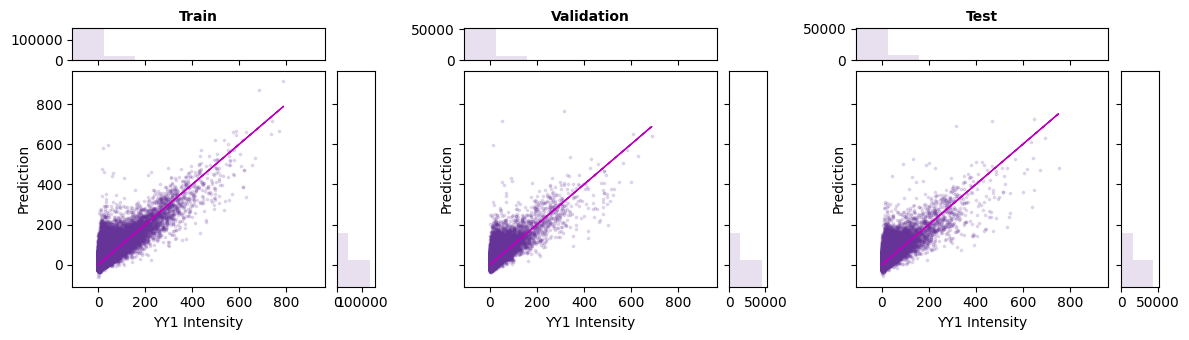

In [14]:
ob_preds = PickleLoad(pn_ob_preds)

ob_predpairs = Data2Divided([np.squeeze(x) for x in [ob_preds, tri_tpacks[1]]],
                               split = yy1_split_transaug)

mima = [F([F(x) for x in [ob_preds, tri_tpacks[1]]]) for F in [np.min, np.max]]


sh_args_1 = sh_args.copy()
sh_args_1.update({'bounds': mima})

MultiPlot(ob_predpairs, **mp_args,  
          plt_mode = [ScaHistPlot, sh_args_1])

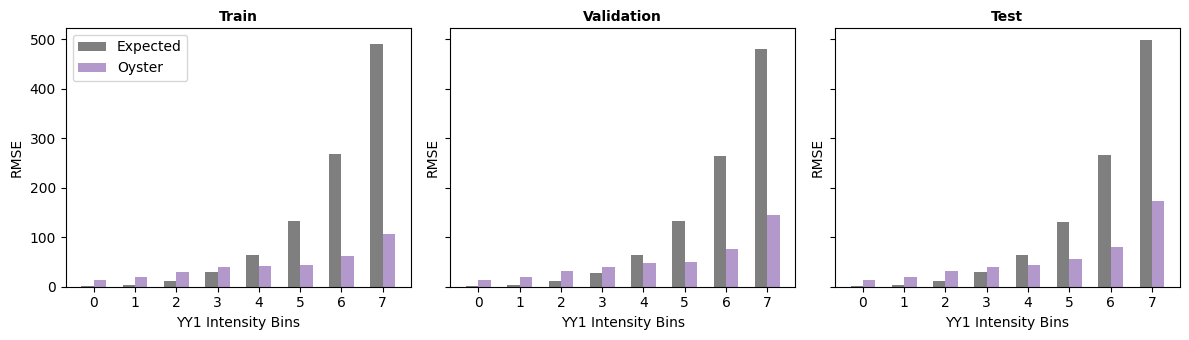

In [15]:
pse = 1e-8

subject = tri_tpacks[1].reshape(-1)
x, y = FFTKDE(bw='silverman', kernel='gaussian').fit(np.log(subject + pse), weights=None).evaluate()
expected = np.exp(x[np.argmax(y)])
expected

Bin_base = {'multi': False, 'uni': np.arange(bins), 'useweights': False, 'switchaxis': None}

BM_args = {**Bin_base, 
           'metrics_mode': RMSE_mode,
           'summarize_mode': None, 
           'incl_uni': True, 'incl_props': True, 'props': True}

BM_args_vsexp = BM_args.copy() 
BM_args_vsexp.update({'constant': expected})

ob_BM_vsexp = [BinMetrics(tri_tpacks[1][O].reshape(-1), ob_preds[O].reshape(-1), inp3 = None, 
                             bind = tri_tpacks[3][O].reshape(-1), **BM_args_vsexp) 
                             for O in yy1_split_transaug]

ob_BM_vsexp2 = [[x[0], [x[2], x[1]]] for x in ob_BM_vsexp]

maxo = np.max(np.stack([x[1] for x in ob_BM_vsexp2]))

bp_argsX = {'color': ['black', 'rebeccapurple'],
            'ylabel': 'RMSE',
            'width': 0.3,  
            'xlabel': 'YY1 Intensity Bins',
            'labelheight': False, 
            'alpha': 0.5, 
            'group': ['Expected', 'Oyster'],
            'bounds': (0, maxo * 1.05) }


mp_args = {'multi': True, 'paired': False, 'transpose': True, 
           'columntitle': divset, 
           'rowtitle': None, 'rowtitle_rotation': True,
           'figsize': (12, 3.5), 'fontsize': 10, 'customgrid': (1, 3),
           'sharey': True, 'sharex': True}

mp_args_2 = mp_args.copy()
mp_args_2.update({'sharex': True, 'transpose': False})

MultiPlot(ob_BM_vsexp2, **mp_args_2, indiv_args = {'legend': [True, False, False]}, 
          plt_mode = [BarPlot, bp_argsX])

## Determinants

In [16]:
# deter_seq2 = FeatExtract(ob_mod, 'DA', [*data_ready[:2]], batchsize = 256)
# deter_epi2 = FeatExtract(ob_mod, 'DB', [*data_ready[:2]], batchsize = 256)

# PickleDump([deter_seq2, deter_epi2], pn_RO_bests + 'deters2')

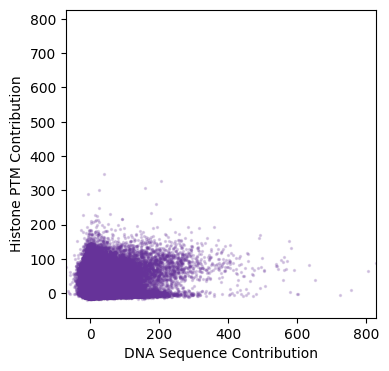

In [17]:
deter_seq2, deter_epi2 = PickleLoad(pn_RO_bests + 'deters2')

ScaPlot([x.reshape(-1) for x in [deter_seq2, deter_epi2]], 
        fontsize = 10, figsize = (4,4), 
        alpha = 0.2, pointsize= 2, color = 'rebeccapurple', 
        xlabel = 'DNA Sequence Contribution', ylabel = 'Histone PTM Contribution', sharebounds = True)

In [28]:
deter_seq_prop2, deter_epi_prop2 = ((np.abs(x)/ (np.abs(deter_epi2)+ np.abs(deter_seq2))).reshape(-1) for x in [deter_seq2, deter_epi2])

biny = tri_tpacks[3].reshape(-1)

In [29]:
deter_props_binmeans2 = BinFunc(biny, [deter_seq_prop2, deter_epi_prop2], incl_uni=True)

0.5544337 0.44556624


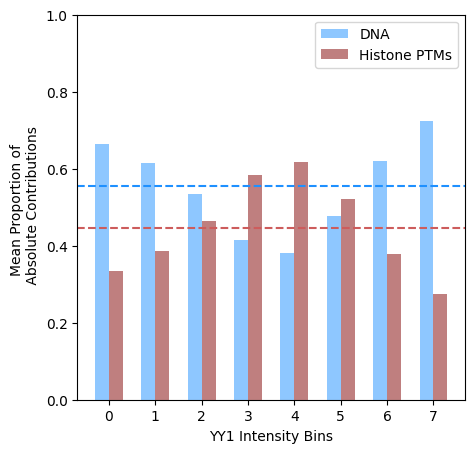

In [30]:
bp_argsX2 = {
            'xlabel': 'YY1 Intensity Bins',
            'ylabel': 'Mean Proportion of \n Absolute Contributions',
            'group': ['DNA', 'Histone PTMs'], 'legend': True,
            'color': ['dodgerblue', 'maroon'],
            'alpha': 0.5, 'width': 0.3, 'bounds': (0, 1),
            'labelheight': False}

ax = BarPlot(deter_props_binmeans2,  **bp_argsX2)
ax.axhline(np.mean(deter_props_binmeans2[1][0]), ls = '--', color = 'dodgerblue')
ax.axhline(np.mean(deter_props_binmeans2[1][1]), ls = '--', color = 'indianred')
print(np.mean(deter_props_binmeans2[1][0]), np.mean(deter_props_binmeans2[1][1]))

## k-motifs

In [18]:
human_core_motifs = '../../Essentials/motif_databases/HUMAN/HOCOMOCOv11_core_HUMAN_mono_meme_format.meme'

name_idx = 1
all_names, all_matrixes = MEME2Motifs(human_core_motifs, name_idx = name_idx)

all_names_filt = [a.split('_HUMAN')[0] for a in all_names]
all_names_filt[:10]

['AHR',
 'AIRE',
 'ALX1',
 'ANDR',
 'AP2A',
 'AP2B',
 'AP2C',
 'ARI5B',
 'ARNT',
 'ASCL1']

In [19]:
shif_names2, shif_matrixes2 = [], []

leno = best_oyster_config2['A_H_size']

shif_idxs2 = []

idx_counter = 0
for n,m in zip(all_names_filt, all_matrixes):
    shifm, shifn = ShiftedMotifs(m, length = leno, name = n)
    shif_names2.extend(shifn)
    shif_matrixes2.extend(shifm)

    lenoz = len(shifn)

    shif_idxs2.append(np.arange(lenoz) + idx_counter)

    idx_counter += lenoz

print(len(shif_matrixes2), len(shif_names2))

2851 2851


In [24]:
# sw = True
# uniq = True

# hys_args = {'mod': 'A', 'dir_sym': best_oyster_config2['A_dir_sym'], 
#             'random_seqs': 20000, 'unique': uniq, 
#             'revcomp': True, 
#             'newmeth': True, 'scoreweight': sw, 'batchsize': 8192}

# shif_scores2 = []

# for ip, ppm in enumerate(shif_matrixes2):
#     shif_scores2.append(Oyster_ScorePPM_v2(ob_mod, ppm, **hys_args))
#     if ip % 10 == 0: print(f'finished {ip}')

# shif_scores2 = np.squeeze(np.stack(shif_scores2))

# PickleDump(shif_scores2, pn_RO_bests + 'shif_scores2')

In [22]:
shif_scores2 = PickleLoad(pn_RO_bests + 'shif_scores2')

In [23]:
mino, maxo = (f(shif_scores2) for f in [np.min, np.max])
print(mino, maxo)

pdo = pd.DataFrame(data = np.array(shif_names2), columns = ['k-Motif'])

poss = np.arange(1, 10)
pdo[poss] = shif_scores2

shif_scores_maxs2 = np.max(shif_scores2, axis = 1)
sorto = np.argsort(shif_scores_maxs2)[::-1]

pdx = pdo.iloc[sorto].iloc[:40]

pdx_sty = pdx.style.format(precision=3).background_gradient(cmap = 'Purples', axis = None, subset = poss,
                                                            vmin = mino, vmax = maxo)
pdx_sty

-169.88215763579646 906.969162589926


,k-Motif,1,2,3,4,5,6,7,8,9
2550,TYY1_3,347.653,246.941,440.996,906.969,880.872,906.969,440.996,246.941,347.653
2549,TYY1_2,344.550,245.121,437.277,906.599,873.601,906.599,437.277,245.121,344.550
2551,TYY1_4,302.259,213.872,382.594,776.683,762.537,776.683,382.594,213.872,302.259
2548,TYY1_1,293.199,208.212,371.990,775.356,743.697,775.356,371.990,208.212,293.199
2552,TYY1_5,282.895,198.812,356.798,720.045,711.351,720.045,356.798,198.812,282.895
2656,ZFP42_6,248.361,176.550,311.094,635.506,602.143,635.506,311.094,176.550,248.361
2553,TYY1_6,248.499,173.770,311.734,627.627,621.221,627.627,311.734,173.770,248.499
2554,TYY1_7,246.506,173.436,309.933,627.517,613.486,627.517,309.933,173.436,246.506
2655,ZFP42_5,246.962,176.164,309.761,626.516,597.287,626.516,309.761,176.164,246.962
2555,TYY1_8,218.602,154.920,275.479,562.593,544.971,562.593,275.479,154.920,218.602


#### Summarised Motifs

In [25]:
motif_scores = np.stack([np.mean(shif_scores2[ido], axis = 0) for ido in shif_idxs2])
motif_scores.shape

(401, 9)

In [26]:
mino, maxo = (np.round(f(motif_scores),3) for f in [np.min, np.max])
print(mino, maxo)

pdo = pd.DataFrame(data = np.array(all_names_filt), columns = ['k-Motif'])

poss = np.arange(1, 10)
pdo[poss] = motif_scores

shif_scores_maxs2 = np.max(motif_scores, axis = 1)
sorto = np.argsort(shif_scores_maxs2)[::-1]

pdx = pdo.iloc[sorto].iloc[:40]

pdx_sty = pdx.style.format(precision=3).background_gradient(cmap = 'Purples', axis = None, subset = poss,
                                                            vmin = mino, vmax = maxo)
pdx_sty

-166.825 712.87


,k-Motif,1,2,3,4,5,6,7,8,9
328,TYY1,275.658,194.824,348.154,712.870,692.932,712.870,348.154,194.824,275.658
324,THAP1,192.882,133.446,232.015,466.121,413.844,466.121,232.015,133.446,192.882
344,ZFP42,181.207,128.050,222.974,441.618,412.147,441.618,222.974,128.050,181.207
306,TAF1,84.532,54.920,83.517,134.423,69.144,134.423,83.517,54.920,84.532
288,SP2,59.591,31.605,23.611,-34.463,-166.825,-34.463,23.611,31.605,59.591
289,SP3,58.434,31.160,23.312,-34.056,-163.355,-34.056,23.312,31.160,58.434
381,ZN528,56.472,35.828,49.215,57.105,3.493,57.105,49.215,35.828,56.472
378,ZN467,56.169,30.708,23.742,-33.613,-155.113,-33.613,23.742,30.708,56.169
221,NRF1,55.608,29.429,23.709,-31.279,-154.165,-31.279,23.709,29.429,55.608
287,SP1,55.554,28.831,21.306,-32.298,-155.993,-32.298,21.306,28.831,55.554


## k-motifs

In [ ]:
human_core_motifs = '../../Essentials/motif_databases/HUMAN/HOCOMOCOv11_core_HUMAN_mono_meme_format.meme'

name_idx = 1
all_names, all_matrixes = MEME2Motifs(human_core_motifs, name_idx = name_idx)

all_names_filt = [a.split('_HUMAN')[0] for a in all_names]
all_names_filt[:10]

['AHR',
 'AIRE',
 'ALX1',
 'ANDR',
 'AP2A',
 'AP2B',
 'AP2C',
 'ARI5B',
 'ARNT',
 'ASCL1']

In [ ]:
shif_names2, shif_matrixes2 = [], []

leno = best_oyster_config2['A_H_size']

shif_idxs2 = []

idx_counter = 0
for n,m in zip(all_names_filt, all_matrixes):
    shifm, shifn = ShiftedMotifs(m, length = leno, name = n)
    shif_names2.extend(shifn)
    shif_matrixes2.extend(shifm)

    lenoz = len(shifn)

    shif_idxs2.append(np.arange(lenoz) + idx_counter)

    idx_counter += lenoz

print(len(shif_matrixes2), len(shif_names2))

2851 2851


In [ ]:
# sw = True
# uniq = True

# hys_args = {'mod': 'A', 'dir_sym': best_oyster_config2['A_dir_sym'], 
#             'random_seqs': 20000, 'unique': uniq, 
#             'revcomp': True, 
#             'newmeth': True, 'scoreweight': sw, 'batchsize': 8192}

# shif_scores2 = []

# for ip, ppm in enumerate(shif_matrixes2):
#     shif_scores2.append(Oyster_ScorePPM_v2(ob_mod, ppm, **hys_args))
#     if ip % 10 == 0: print(f'finished {ip}')

# shif_scores2 = np.squeeze(np.stack(shif_scores2))

# PickleDump(shif_scores2, pn_RO_bests + 'shif_scores2')

In [ ]:
shif_scores2 = PickleLoad(pn_RO_bests + 'shif_scores2')

In [ ]:
mino, maxo = (f(shif_scores2) for f in [np.min, np.max])
print(mino, maxo)

pdo = pd.DataFrame(data = np.array(shif_names2), columns = ['k-Motif'])

poss = np.arange(1, 10)
pdo[poss] = shif_scores2

shif_scores_maxs2 = np.max(shif_scores2, axis = 1)
sorto = np.argsort(shif_scores_maxs2)[::-1]

pdx = pdo.iloc[sorto].iloc[:40]

pdx_sty = pdx.style.format(precision=3).background_gradient(cmap = 'Purples', axis = None, subset = poss,
                                                            vmin = mino, vmax = maxo)
pdx_sty

-169.88215763579646 906.969162589926


,k-Motif,1,2,3,4,5,6,7,8,9
2550,TYY1_3,347.653,246.941,440.996,906.969,880.872,906.969,440.996,246.941,347.653
2549,TYY1_2,344.550,245.121,437.277,906.599,873.601,906.599,437.277,245.121,344.550
2551,TYY1_4,302.259,213.872,382.594,776.683,762.537,776.683,382.594,213.872,302.259
2548,TYY1_1,293.199,208.212,371.990,775.356,743.697,775.356,371.990,208.212,293.199
2552,TYY1_5,282.895,198.812,356.798,720.045,711.351,720.045,356.798,198.812,282.895
2656,ZFP42_6,248.361,176.550,311.094,635.506,602.143,635.506,311.094,176.550,248.361
2553,TYY1_6,248.499,173.770,311.734,627.627,621.221,627.627,311.734,173.770,248.499
2554,TYY1_7,246.506,173.436,309.933,627.517,613.486,627.517,309.933,173.436,246.506
2655,ZFP42_5,246.962,176.164,309.761,626.516,597.287,626.516,309.761,176.164,246.962
2555,TYY1_8,218.602,154.920,275.479,562.593,544.971,562.593,275.479,154.920,218.602


#### Summarised Motifs

In [ ]:
motif_scores = np.stack([np.mean(shif_scores2[ido], axis = 0) for ido in shif_idxs2])
motif_scores.shape

(401, 9)

In [ ]:
mino, maxo = (np.round(f(motif_scores),3) for f in [np.min, np.max])
print(mino, maxo)

pdo = pd.DataFrame(data = np.array(all_names_filt), columns = ['k-Motif'])

poss = np.arange(1, 10)
pdo[poss] = motif_scores

shif_scores_maxs2 = np.max(motif_scores, axis = 1)
sorto = np.argsort(shif_scores_maxs2)[::-1]

pdx = pdo.iloc[sorto].iloc[:40]

pdx_sty = pdx.style.format(precision=3).background_gradient(cmap = 'Purples', axis = None, subset = poss,
                                                            vmin = mino, vmax = maxo)
pdx_sty

-166.825 712.87


,k-Motif,1,2,3,4,5,6,7,8,9
328,TYY1,275.658,194.824,348.154,712.870,692.932,712.870,348.154,194.824,275.658
324,THAP1,192.882,133.446,232.015,466.121,413.844,466.121,232.015,133.446,192.882
344,ZFP42,181.207,128.050,222.974,441.618,412.147,441.618,222.974,128.050,181.207
306,TAF1,84.532,54.920,83.517,134.423,69.144,134.423,83.517,54.920,84.532
288,SP2,59.591,31.605,23.611,-34.463,-166.825,-34.463,23.611,31.605,59.591
289,SP3,58.434,31.160,23.312,-34.056,-163.355,-34.056,23.312,31.160,58.434
381,ZN528,56.472,35.828,49.215,57.105,3.493,57.105,49.215,35.828,56.472
378,ZN467,56.169,30.708,23.742,-33.613,-155.113,-33.613,23.742,30.708,56.169
221,NRF1,55.608,29.429,23.709,-31.279,-154.165,-31.279,23.709,29.429,55.608
287,SP1,55.554,28.831,21.306,-32.298,-155.993,-32.298,21.306,28.831,55.554


## From EpiProfiles

In [18]:
pack_histone_scores = PickleLoad(mainfolder + 'pack_histone_scores')

his_scores_Tri = np.expand_dims(np.swapaxes(pack_histone_scores, -1, -2), axis = -1)


H_size = best_oyster_config2['B_H_size']
his_scores_win = TridentWindow(his_scores_Tri, H_size)

his_scores_win.shape

(3800000, 11, 9, 1)

In [19]:
pack_histone_scores = PickleLoad(mainfolder + 'pack_histone_scores')

histone_scores_Tri = np.expand_dims(np.swapaxes(pack_histone_scores, -1, -2), axis = -1)

oss_args = {'H_size': best_oyster_config2['B_H_size'], 'mod': 'B', 
            'chunk': True, 'batchsize': 2024, 
            'dir_sym': False}                 ###best_oyster_config['B_dir_sym']} SHOULD BE FALSE FOR HIS CLUSTERS. 


# his_contribs2 = Oyster_Score_Signals(ob_mod, histone_scores_Tri, **oss_args)

# PickleDump(his_contribs2,  pn_RO_bests + 'his_contribs2')

In [31]:
# num_clust = 100

# osc_args = {'H_size': best_oyster_config2['B_H_size'],
#             'num_clusters': num_clust, 'sample': 1000000}
          

# his_clustered2 = Oyster_SigCluster(his_scores_Tri, **osc_args)

# PickleDump(his_clustered2,  pn_RO_bests + 'his_clustered2')

11
(1000000, 9)
finished: 0
(1000000, 9)
finished: 1
(1000000, 9)
finished: 2
(1000000, 9)
finished: 3
(1000000, 9)
finished: 4
(1000000, 9)
finished: 5
(1000000, 9)
finished: 6
(1000000, 9)
finished: 7
(1000000, 9)
finished: 8
(1000000, 9)
finished: 9
(1000000, 9)
finished: 10


In [20]:
his_contribs2 = PickleLoad(pn_RO_bests + 'his_contribs2')
his_clustered2 = PickleLoad(pn_RO_bests + 'his_clustered2')

print(his_contribs2.shape, his_clustered2.shape)

(3800000, 11, 6, 1) (3800000, 11)


In [ ]:


histones = ['H3K4me3', 'H3K27ac', 'H3K27me3', 'H3K4me1', 'H3K36me3', 'H3K9me3', 'H3K9ac', 
            'H3K4me2', 'H4K20me1', 'H2AFZ', 'H3K79me2']

import seaborn as sns

his_clust_names2 = []
his_clust_acts2 = []
his_clust_contribs2 = []

for ih, h in enumerate(histones):
    contribs = his_contribs2[:, ih, :, 0]
    cluster_idxs = [np.where(his_clustered2[:, ih] == n)[0] for n in np.arange(num_clust)]
    
    meanos_act = np.stack([np.mean(his_scores_win[:, ih, :, 0][cidx], axis = 0) for cidx in cluster_idxs]) 
    meanos_contribs = np.stack([np.mean(contribs[cidx], axis = 0) for cidx in cluster_idxs]) 

    obx = sns.clustermap(np.squeeze(meanos_act), col_cluster = False)
    neworder = obx.dendrogram_row.reordered_ind

    meanos_act_no = meanos_act[neworder]
    his_clust_acts2.append(meanos_act_no)

    meanos_contribs_no = meanos_contribs[neworder]
    his_clust_contribs2.append(meanos_contribs_no)

    cluster_names = [h + '_' + str(n) for n in np.arange(num_clust)]
    his_clust_names2.extend(cluster_names)


his_clust_acts2 = np.vstack(his_clust_acts2)
his_clust_contribs2 = np.vstack(his_clust_contribs2)

[PickleDump(x, pn_RO_bests + y) for x,y in zip([his_clust_names2, his_clust_acts2, his_clust_contribs2], 
                                                ['his_clust_names2', 'his_clust_acts2', 'his_clust_contribs2'])]

In [21]:
his_clust_names2, his_clust_acts2, his_clust_contribs2 = [PickleLoad(pn_RO_bests + y) 
                                                       for y in ['his_clust_names2', 'his_clust_acts2', 'his_clust_contribs2']]

In [22]:
mino, maxo = (f(his_clust_contribs2) for f in [np.min, np.max])
print(mino, maxo)

pdo = pd.DataFrame(data = np.array(his_clust_names2), columns = ['Cluster'])

poss = np.arange(6)
pdo[poss] = his_clust_contribs2

his_clust_contribs_maxs2 = np.max(his_clust_contribs2, axis = 1)
sorto = np.argsort(his_clust_contribs_maxs2)[::-1]

pdx = pdo.iloc[sorto].iloc[:45]

pdx_sty = pdx.style.format(precision=3).background_gradient(cmap = 'Purples', axis = None, subset = poss, 
                                                            vmin = mino, vmax = maxo)
pdx_sty

-101.99561 133.62198


,Cluster,0,1,2,3,4,5
996,H2AFZ_96,16.116,78.494,133.622,17.121,-101.996,-62.379
897,H4K20me1_97,-54.865,85.178,52.561,42.528,-61.240,-11.702
979,H2AFZ_79,8.826,47.801,81.381,9.257,-60.463,-38.255
984,H2AFZ_84,7.792,43.117,75.640,4.089,-51.514,-36.213
988,H2AFZ_88,8.113,41.416,67.518,-2.034,-43.850,-33.893
898,H4K20me1_98,-40.706,63.294,38.804,31.263,-45.267,-8.986
186,H3K27ac_86,18.718,34.352,59.897,-56.150,7.904,4.284
985,H2AFZ_85,5.427,34.636,58.544,-0.403,-38.000,-28.271
899,H4K20me1_99,-35.757,55.207,34.484,28.525,-39.986,-6.742
962,H2AFZ_62,4.158,29.114,51.433,-2.618,-31.040,-25.099


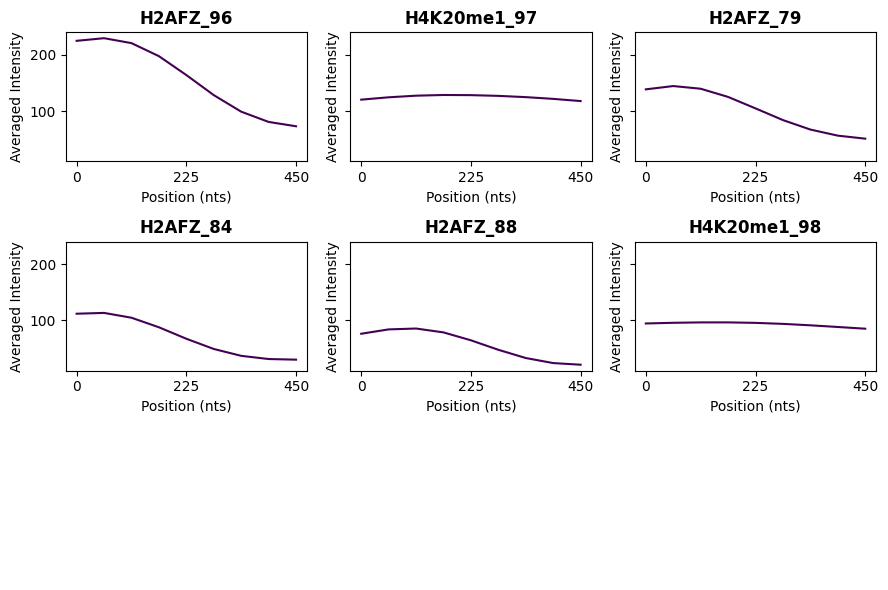

In [25]:


mp_args = {'multi': True, 'paired': False, 'transpose': False, 
           'columntitle': None,
           'rowtitle': None, 'rowtitle_rotation': True,
           'figsize': (9, 6), 'fontsize': 10,
           'sharey': True, 'sharex': False, 


           'indiv_args': {'suptitle': pdx.iloc[:6]['Cluster'].to_list()}}

line_args = {'xticklabel': [0, 9*50 // 2, 9*50], 'xlabel': 'Position (nts)', 'ylabel': 'Averaged Intensity'}



MultiPlot(his_clust_acts2[pdx.index[:6]], **mp_args, customgrid=(3,3),
                 plt_mode = [LinePlot, line_args])

In [ ]:
his_clust_contribs_mins

array([-43.2307  , -18.858757, -19.5364  , ...,  -7.122113,  -8.151381,
        -7.945551], dtype=float32)

In [42]:
pdo = pd.DataFrame(data = np.array(his_clust_names2), columns = ['Histone Cluster'])

poss = np.arange(6)
pdo[poss] = his_clust_contribs2

sorto = np.argsort(his_clust_contribs_maxs2)[::1]

pdx = pdo.iloc[sorto].iloc[:45]

pdx_sty = pdx.style.format(precision=3).background_gradient(cmap = 'Purples', axis = None, subset = poss,
                                                            vmin = mino, vmax = maxo)
pdx_sty

,Histone Cluster,0,1,2,3,4,5
510,H3K9me3_10,-0.016,-0.001,0.002,-0.002,-0.004,-0.008
535,H3K9me3_35,-0.012,-0.003,0.004,0.004,-0.003,-0.007
570,H3K9me3_70,-0.021,0.002,0.005,0.002,-0.003,-0.013
543,H3K9me3_43,-0.017,-0.005,-0.000,0.005,-0.006,-0.010
525,H3K9me3_25,-0.015,-0.008,-0.001,0.005,-0.010,-0.007
526,H3K9me3_26,-0.013,-0.007,-0.003,0.006,-0.006,-0.007
547,H3K9me3_47,-0.016,-0.009,-0.002,0.006,-0.009,-0.008
509,H3K9me3_9,-0.016,-0.010,-0.003,0.006,-0.010,-0.008
548,H3K9me3_48,-0.017,-0.010,-0.002,0.007,-0.011,-0.009
541,H3K9me3_41,-0.017,-0.012,-0.000,0.007,-0.014,-0.007


In [ ]:
np.stack(his_clust_acts[x] for x in [69]

array([164.15433, 196.9642 , 244.7582 , 303.1064 , 366.3206 , 427.80142,
       481.25073, 523.0353 , 549.1854 , 556.5981 , 544.0025 ],
      dtype=float32)

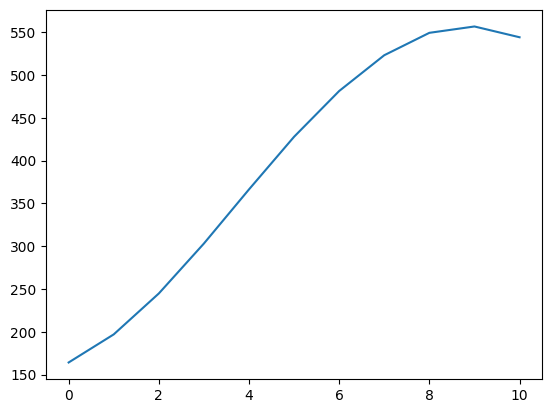

In [ ]:
plt.plot(his_clust_acts[699])

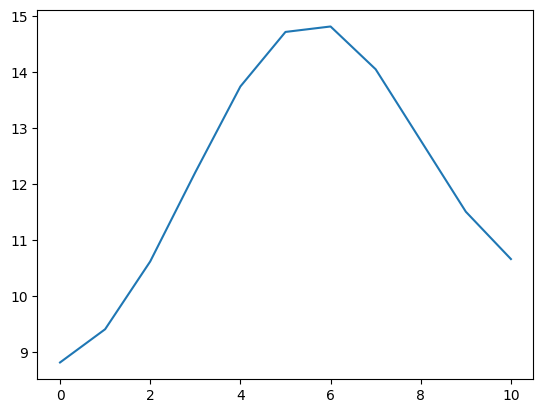

In [ ]:
plt.plot(his_clust_acts[115])

In [ ]:
meanos_contribs.shape

(100, 6)

In [ ]:
cluster_idxs[0][0].shape

(11579,)

In [ ]:
obx.dendrogram_row.reordered_ind

[73,
 6,
 74,
 33,
 88,
 55,
 94,
 29,
 86,
 41,
 99,
 53,
 10,
 67,
 44,
 51,
 96,
 75,
 90,
 0,
 20,
 81,
 16,
 97,
 91,
 14,
 56,
 83,
 52,
 11,
 32,
 59,
 37,
 7,
 62,
 21,
 42,
 9,
 19,
 38,
 80,
 68,
 76,
 69,
 18,
 15,
 65,
 34,
 63,
 60,
 84,
 2,
 5,
 40,
 95,
 17,
 78,
 82,
 22,
 58,
 8,
 46,
 79,
 50,
 71,
 98,
 49,
 36,
 93,
 27,
 85,
 3,
 77,
 30,
 57,
 24,
 92,
 39,
 66,
 26,
 48,
 45,
 43,
 4,
 35,
 61,
 1,
 54,
 25,
 70,
 89,
 12,
 28,
 31,
 23,
 87,
 13,
 64,
 47,
 72]

In [ ]:
histone_scores_Tri = np.expand_dims(np.swapaxes(pack_histone_scores, -1, -2), axis = -1)

In [ ]:
histone_scores_Tri.shape

(100000, 11, 46, 1)

In [ ]:
ST = np.lib.stride_tricks.sliding_window_view

winshape = (11, 15, 1)
his_win = ST(histone_scores_Tri, (1, *winshape))

his_win_rs = his_win.reshape(-1, *winshape)
his_win_rs.shape

(3200000, 11, 15, 1)

In [ ]:
his_win_rs[0][0]

array([[12.578204 ],
       [10.095645 ],
       [ 6.836139 ],
       [ 7.7332745],
       [10.624178 ],
       [16.92419  ],
       [27.00757  ],
       [33.141445 ],
       [39.88678  ],
       [41.45843  ],
       [37.90813  ],
       [35.510284 ],
       [30.523544 ],
       [28.312237 ],
       [24.127556 ]], dtype=float32)

In [ ]:
his_win_rs[1][0]

array([[10.095645 ],
       [ 6.836139 ],
       [ 7.7332745],
       [10.624178 ],
       [16.92419  ],
       [27.00757  ],
       [33.141445 ],
       [39.88678  ],
       [41.45843  ],
       [37.90813  ],
       [35.510284 ],
       [30.523544 ],
       [28.312237 ],
       [24.127556 ],
       [20.814499 ]], dtype=float32)